# Income Prediction & Customer Segmentation Analysis

**Author:** Phani Tarun M  
**Date:** February 2026  

---

## Project Overview

This project develops two complementary machine learning solutions using the provided dataset:

1. **Classification Model** - A supervised learning model to predict whether an individual belongs to the high-income category. The objective is to support targeted marketing efforts by accurately identifying high-value customers.

2. **Segmentation Model** - An unsupervised clustering approach to group individuals into distinct segments based on demographic and financial characteristics. The goal is to uncover actionable customer groups that enable differentiated marketing strategies and optimized resource allocation.

The analysis includes data exploration, preprocessing, model development, evaluation, and business interpretation of results. Emphasis is placed on model performance, interpretability, and practical recommendations aligned with business objectives.


In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn
!pip install xgboost optuna plotly ipython

## 1.1 Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve, silhouette_score,
    accuracy_score, precision_score, recall_score, f1_score

)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from IPython.display import display
from pathlib import Path

import optuna
import optuna.visualization as vis

/Users/phanitarunmunukuntla/Desktop/JPMC/take-home-test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2 Global Plot Settings

In [3]:
def set_plot_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_palette("colorblind")
    sns.set_context("notebook", font_scale=0.9)

## 2.1 Load and Read Data

In [4]:
def load_data(data_path: str, column_path: str) -> pd.DataFrame:
    """
    Load raw dataset and assign column names.

    Parameters:
        data_path (str): Path to the data file.
        column_path (str): Path to the file containing column names.

    Returns:
        pd.DataFrame: Loaded dataset with proper column headers.
    """

    with open(column_path, "r") as f:
        column_names = [col.strip() for col in f if col.strip()]

    df = pd.read_csv(data_path, header=None)
    df.columns = column_names
    return df

## 2.2 Missing Value Handling

In [5]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean missing values in the dataset. Replaces '?' with NaN, imputes numerical features using median, and categorical features using mode.

    Parameters:
        df (pd.DataFrame): Raw input dataframe.

    Returns:
        pd.DataFrame: Cleaned dataframe with imputed values.
    """

    print_section("Missing Value Handling", level=2)
    df = df.copy()
    df.replace("?", np.nan, inplace=True)

    numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = df.select_dtypes(include=["object", "string", "category"]).columns

    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())

    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    print("Missing values handled successfully.")
    return df

## 2.3 Encode Categorical Variables

In [6]:
def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode categorical features using label encoding.

    Parameters:
        df (pd.DataFrame): Input dataset with categorical columns.

    Returns:
        pd.DataFrame: Dataset with encoded categorical features.
    """

    df = df.copy()
    le = LabelEncoder()

    for col in df.select_dtypes(include=["object", "string", "category"]).columns:
        df[col] = le.fit_transform(df[col])

    return df

## 2.4 Feature Engineering - Wage Features

In [7]:
def add_income_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create income-related engineered features. Adds wage indicator, log-transformed financial variables, and an income proxy feature (feature_engineering_v1).

    Parameters:
        df (pd.DataFrame): Input dataset.

    Returns:
        pd.DataFrame: Dataset with added income features.
    """

    print_section("Feature Engineering – Income Signals", level=2)
    df = df.copy()

    # Binary wage indicator
    df["has_hourly_wage"] = (df["wage per hour"] > 0).astype(int)

    # Log transforms (handle skew)
    df["log_hourly_wage"] = np.log1p(df["wage per hour"])
    df["log_capital_gain"] = np.log1p(df["capital gains"])
    df["log_capital_loss"] = np.log1p(df["capital losses"])

    # Income proxy (annualized wage + investment income)
    df["income_proxy"] = (df["wage per hour"] * df["weeks worked in year"] + df["capital gains"] + df["dividends from stocks"])
    return df

## 3.1 Exploratory Data Analysis (EDA)

In [8]:
def run_basic_eda(df: pd.DataFrame, target: str):
    """
    Perform high-level exploratory data analysis. Displays dataframe structure, descriptive statistics, and normalized target distribution.

    Parameters:
        df (pd.DataFrame): Input dataset.
        target (str): Target column name.
    """

    print_section("Dataframe Info", level=2)
    display(df.info())

    print_section("Descriptive stats", level=2)
    display(df.describe(include="all").T)

    print_section("target Distribution", level=2)
    display(df[target].value_counts(normalize=True))

In [9]:
def eda_categorical_summary(df: pd.DataFrame, categorical_cols: list, top_k=5):
    """
    Display frequency summary of categorical features. Shows top_k most frequent categories for each categorical column.

    Parameters:
        df (pd.DataFrame): Input dataset.
        categorical_cols (list): List of categorical column names.
        top_k (int): Number of top categories to display per feature.
    """

    for col in categorical_cols:
        print_section(col, level=2)
        display(df[col].value_counts().head(top_k))

In [10]:
def eda_numerical_summary(df: pd.DataFrame, numerical_cols: list):
    """
    Display descriptive statistics for numerical features. Provides summary metrics such as mean, std, min, max, and quartiles for all numerical columns.

    Parameters:
        df (pd.DataFrame): Input dataset.
        numerical_cols (list): List of numerical column names.
    """

    print_section("Summary of numerical columns", level=2)
    display(df.describe())

In [11]:
def plot_numerical_distributions(df: pd.DataFrame, numerical_cols: list):
    """
    Visualize distributions of numerical features. Generates histogram plots with KDE overlays for each numerical column to inspect distribution shape and skewness.

    Parameters:
        df (pd.DataFrame): Input dataset.
        numerical_cols (list): List of numerical column names.
    """

    print_section("Numerical Feature Distributions", level=2)
    num_rows = (len(numerical_cols) + 2) // 3
    plt.figure(figsize=(20, 5 * num_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(num_rows, 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_categorical_distributions(df: pd.DataFrame, categorical_cols: list):
    """
    Visualize frequency distributions of categorical features. Generates count plots for each categorical column to examine category proportions and class imbalance.

    Parameters:
        df (pd.DataFrame): Input dataset.
        categorical_cols (list): List of categorical column names.
    """

    print_section("Categorical Feature Distributions", level=2)
    num_rows = (len(categorical_cols) + 2) // 3
    plt.figure(figsize=(20, 6 * num_rows))

    for i, col in enumerate(categorical_cols):
        plt.subplot(num_rows, 3, i + 1)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_target_distribution(df: pd.DataFrame, target: str):
    """
    Visualize target class distribution. Generates a pie chart showing the proportion of each target class to assess class imbalance.

    Parameters:
        df (pd.DataFrame): Input dataset.
        target (str): Target column name.
    """

    print_section("Target Distribution - Pie chart", level=2)
    df[target].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, ylabel="")
    plt.title("Target Class Distribution")
    plt.show()

In [14]:
def plot_correlation_heatmap(df: pd.DataFrame, numerical_cols: list):
    """
    Visualize correlations between numerical features. Generates a heatmap of the correlation matrix to identify linear relationships and potential multicollinearity.

    Parameters:
        df (pd.DataFrame): Input dataset.
        numerical_cols (list): List of numerical column names.
    """

    print_section("Correlation Heatmap", level=2)
    plt.figure(figsize=(14, 10))
    sns.heatmap(df[numerical_cols].corr(), cmap="coolwarm", annot=True, center=0)
    plt.title("Correlation Matrix")
    plt.show()

In [15]:
def plot_age_vs_income_label(df: pd.DataFrame):
    """
    Boxplot showing age distribution across income groups.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Age Distribution by Income Group (Boxplot)", level=2)
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="label",y="age",data=df)

    plt.title("Age Distribution by Income Group")
    plt.xlabel("Income Group")
    plt.ylabel("Age")
    plt.tight_layout()
    plt.show()

In [16]:
def plot_education_vs_wage(df: pd.DataFrame):
    """
    Boxplot showing wage distribution across education levels.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Education vs Wage per Hour (Boxplot)", level=2)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="education", y="wage per hour", data=df)

    plt.xticks(rotation=90)
    plt.yscale("log")                # handle skew
    plt.title("Wage Distribution by Education Level")
    plt.tight_layout()
    plt.show()

In [17]:
def plot_class_worker_vs_wage(df: pd.DataFrame):
    """
    Boxplot showing wage distribution across class of worker categories.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Class of Worker vs Wage per Hour (Boxplot)", level=2)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="class of worker", y="wage per hour", data=df)

    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.title("Wage Distribution by Class of Worker")
    plt.tight_layout()
    plt.show()

In [18]:
def plot_sex_vs_income_proxy(df: pd.DataFrame):
    """
    Boxplot showing income proxy distribution across sex categories.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Sex vs Income Proxy (Boxplot)", level=2)
    df_temp = df.copy()
    df_temp["income_proxy"] = (df_temp["wage per hour"] * df_temp["weeks worked in year"] + df_temp["capital gains"] + df_temp["dividends from stocks"])

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="sex", y="income_proxy", data=df_temp)

    plt.yscale("log")
    plt.title("Income Proxy Distribution by Sex")
    plt.tight_layout()
    plt.show()

In [19]:
def plot_self_employed_vs_income_proxy(df: pd.DataFrame):
    """
    Boxplot showing income proxy distribution by self-employment status.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Self-Employed Status vs Income Proxy (Boxplot)", level=2)
    df_temp = df.copy()
    df_temp["income_proxy"] = (df_temp["wage per hour"] * df_temp["weeks worked in year"] + df_temp["capital gains"] + df_temp["dividends from stocks"])

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="own business or self employed", y="income_proxy", data=df_temp)

    plt.yscale("log")
    plt.title("Income Proxy by Self-Employment Status")
    plt.tight_layout()
    plt.show()

In [20]:
def plot_region_vs_income_proxy(df: pd.DataFrame):
    """
    Boxplot showing income proxy distribution across regions.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Region vs Income Proxy (Boxplot)", level=2)
    df_temp = df.copy()
    df_temp["income_proxy"] = (df_temp["wage per hour"] * df_temp["weeks worked in year"] + df_temp["capital gains"] + df_temp["dividends from stocks"])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="region of previous residence", y="income_proxy", data=df_temp)

    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.title("Income Proxy Distribution by Region")
    plt.tight_layout()
    plt.show()

In [21]:
def plot_sex_proportion_pie(df: pd.DataFrame):
    """
    Pie chart showing overall male vs female distribution.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Overall Sex Distribution (Pie Chart)", level=2)
    sex_counts = df["sex"].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(sex_counts, labels=sex_counts.index, autopct="%1.1f%%", startangle=90)

    plt.title("Sex Proportion in Dataset")
    plt.tight_layout()
    plt.show()

In [22]:
def plot_mean_wage_by_education(df: pd.DataFrame):
    """
    Bar plot showing average wage per hour by education level.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Education vs Mean Wage per Hour (Bar Plot)", level=2)

    # Compute mean wage per education level
    mean_wage = (df.groupby("education")["wage per hour"].mean().sort_values(ascending=False))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=mean_wage.index, y=mean_wage.values)

    plt.xticks(rotation=90)
    plt.ylabel("Mean Wage per Hour")
    plt.title("Average Wage per Hour by Education Level")
    plt.tight_layout()
    plt.show()

In [23]:
def plot_sex_distribution_by_income(df: pd.DataFrame):
    """
    Side-by-side pie charts showing sex distribution for <50K and >50K income groups.

    Parameters:
        df (pd.DataFrame): Input dataset.
    """

    print_section("Sex Distribution by Income Group (<50K vs >50K)", level=2)

    # Split dataset
    df_low = df[df["label"] != "50000+."]
    df_high = df[df["label"] == "50000+."]

    # Compute distributions
    low_counts = df_low["sex"].value_counts()
    high_counts = df_high["sex"].value_counts()

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # <50K Pie
    axes[0].pie(low_counts, labels=low_counts.index, autopct="%1.1f%%", startangle=90)
    axes[0].set_title("< 50K Income Group")

    # >50K Pie
    axes[1].pie(high_counts, labels=high_counts.index, autopct="%1.1f%%", startangle=90)
    axes[1].set_title("> 50K Income Group")

    plt.tight_layout()
    plt.show()

In [24]:
def plot_top_categorical_vs_label(df: pd.DataFrame, top_n: int = 6):
    """
    Plot countplots of top categorical features with income label as hue.
    Automatically selects reasonable categorical columns.

    Parameters:
        df (pd.DataFrame): Input dataset.
        top_n (int): Number of top features to consider.
    """

    print_section("Top Categorical Features vs Income Label (Countplots)", level=2)

    # Select categorical columns excluding target
    categorical_cols = df.select_dtypes(include="object").columns.tolist()
    categorical_cols = [col for col in categorical_cols if col != "label"]

    # Filter out very high-cardinality columns
    filtered_cols = [col for col in categorical_cols if df[col].nunique() <= 10]

    # Pick first top_n features
    selected_cols = filtered_cols[:top_n]

    n_cols = 3
    n_rows = (len(selected_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(18, 5 * n_rows))

    for i, col in enumerate(selected_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, hue="label", palette="Set1", order=order)
        plt.title(f"{col} by Income Label")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [25]:
def plot_model_metric_comparison(results: list):
    """
    Compare classification metrics across candidate models. Metrics are grouped together for side-by-side comparison.

    Parameters:
        results (list): Model evaluation results.
    """

    print_section("Model Comparison – Metric-wise Evaluation", level=2)
    df_metrics = pd.DataFrame(results)
    metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

    # Reshape for better grouping
    df_plot = df_metrics.set_index("model_name")[metrics]
    df_plot = df_plot.T  # transpose so metrics are grouped
    ax = df_plot.plot(kind="bar", figsize=(14, 5), width=0.8)
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.legend(title="Model", frameon=False)
    plt.tight_layout()

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontsize=8)

    plt.show()

In [26]:
def plot_roc_comparison(results: list):
    """
    Plot ROC curves for multiple models on the same graph.

    Parameters:
        results (list): List of evaluation dictionaries containing true labels, predicted probabilities, and AUC.
    """

    print_section("ROC Curve Comparison", level=2)
    plt.figure(figsize=(7, 6))

    for r in results:
        fpr, tpr, _ = roc_curve(r["y_true"], r["y_prob"])
        plt.plot(fpr, tpr, label=f'{r["model_name"]} (AUC={r["roc_auc"]:.3f})')

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.show()

In [27]:
def plot_pr_comparison(results: list):
    """
    Plot Precision–Recall curves for multiple models.

    Parameters:
        results (list): List of evaluation dictionaries containing true labels and predicted probabilities.
    """

    print_section("Precision–Recall Curve Comparison", level=2)
    plt.figure(figsize=(7, 6))

    for r in results:
        precision, recall, _ = precision_recall_curve(r["y_true"], r["y_prob"])
        plt.plot(recall, precision, label=r["model_name"])

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve Comparison")
    plt.legend()
    plt.show()

In [28]:
def run_eda_pipeline(df_raw: pd.DataFrame):
    """
    Execute complete exploratory data analysis workflow. Runs summary statistics, distribution plots, relationship analysis, and target diagnostics for the dataset.

    Parameters:
        df_raw (pd.DataFrame): Raw cleaned dataset.
    """

    numerical_cols = df_raw.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = df_raw.select_dtypes(include="object").columns

    run_basic_eda(df_raw, target="label")
    eda_categorical_summary(df_raw, categorical_cols)
    eda_numerical_summary(df_raw, numerical_cols)

    plot_numerical_distributions(df_raw, numerical_cols)
    plot_categorical_distributions(df_raw, categorical_cols)

    # plot_education_vs_wage(df_raw)
    # plot_class_worker_vs_wage(df_raw)
    # plot_sex_vs_income_proxy(df_raw)
    # plot_self_employed_vs_income_proxy(df_raw)
    # plot_region_vs_income_proxy(df_raw)

    plot_age_vs_income_label(df_raw)
    plot_sex_proportion_pie(df_raw)
    plot_mean_wage_by_education(df_raw)
    plot_sex_distribution_by_income(df_raw)
    plot_top_categorical_vs_label(df_raw)
    plot_target_distribution(df_raw, "label")
    plot_correlation_heatmap(df_raw, numerical_cols)

In [29]:
# run_eda_pipeline(df_raw)

## 4.1 Train/Test Split

In [30]:
def split_data(df: pd.DataFrame, target: str, weight_col: str):
    """
    Split dataset into train and test sets with stratification. Separates features, target, and survey weights, and performs an 80-20 stratified split.

    Parameters:
        df (pd.DataFrame): Input dataset.
        target (str): Target column name.
        weight_col (str): Survey weight column name.

    Returns:
        Tuple of X_train, X_test, y_train, y_test, w_train, w_test.
    """

    X = df.drop(target, axis=1)
    y = df[target]
    w = df[weight_col].values

    return train_test_split(X, y, w, test_size = 0.2, random_state = 42, stratify = y)

## 4.2 Classification - Model Training & Evaluation

In [31]:
def train_logistic_regression(X_train: pd.DataFrame, y_train: pd.Series, survey_weights):
    """
    Train a weighted Logistic Regression classifier. Applies feature scaling and fits the model using survey weights to account for stratified sampling.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target labels.
        survey_weights (array-like): Sample weights for training data.

    Returns:
        Pipeline: Trained Logistic Regression pipeline.
    """

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])

    pipeline.fit(X_train, y_train, lr__sample_weight = survey_weights)
    return pipeline

In [32]:
def train_gbm(X_train: pd.DataFrame, y_train: pd.Series, survey_weights):
    """
    Train a weighted Gradient Boosting classifier. Fits a GradientBoosting model using survey weights to reflect population-level importance.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target labels.
        survey_weights (array-like): Sample weights for training data.

    Returns:
        Pipeline: Trained GBM pipeline.
    """

    pipeline = Pipeline([
        ("gbm", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train, gbm__sample_weight = survey_weights)
    return pipeline

In [33]:
def train_xgb(X_train: pd.DataFrame, y_train: pd.Series, survey_weights):
    """
    Train a weighted XGBoost classifier. Adjusts for class imbalance using scale_pos_weight and fits the model with survey weights.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target labels.
        survey_weights (array-like): Sample weights for training data.

    Returns:
        Pipeline: Trained XGBoost pipeline.
    """

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    pipeline = Pipeline([
        ("xgb", XGBClassifier(
            n_estimators=500,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            eval_metric="auc",
            random_state=42,
            n_jobs=-1
        ))
    ])

    pipeline.fit(X_train, y_train, xgb__sample_weight = survey_weights)
    return pipeline

In [34]:
def train_models(X_train: pd.DataFrame, y_train: pd.Series, w_train):
    """
    Train multiple candidate classification models. Fits Logistic Regression, GBM, and XGBoost using survey-weighted training data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target labels.
        w_train (array-like): Sample weights for training data.

    Returns:
        dict: Dictionary of trained models keyed by model name.
    """

    models = {
        "Logistic Regression": train_logistic_regression(X_train, y_train, w_train),
        "GBM": train_gbm(X_train, y_train, w_train),
        "XGBoost": train_xgb(X_train, y_train, w_train)
    }
    return models

In [35]:
def evaluate_model(model, X_test, y_test, model_name = None):
    """
    Evaluate a classification model on test data. Computes key performance metrics and displays classification report and confusion matrix.

    Parameters:
        model: Trained classification model.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): True test labels.
        model_name (str, optional): Name of the model.

    Returns:
        dict: Dictionary containing predictions and evaluation metrics.
    """

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print_section("Classification Report", level=3)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc)

    print_section("Confusion Matrix", level=3)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.show()

    return {
        "model_name": model_name,
        "y_true": y_test,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "roc_auc": roc_auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [36]:
def run_modeling_pipeline(df: pd.DataFrame, hp_tuning_trails: int = 2):
    """
    Execute full supervised modeling workflow. Trains multiple candidate models, evaluates performance, compares metrics, selects a winner based on business criteria, and performs hyperparameter tuning on the selected model.

    Parameters:
        df (pd.DataFrame): Feature-engineered dataset.
        hp_tuning_trails (int): Number of Optuna trials for tuning.

    Returns:
        None
    """

    X_train, X_test, y_train, y_test, w_train, w_test = split_data(df, "label", "weight")
    results = []
    model_configs = [
        ("Logistic Regression", train_logistic_regression),
        ("GBM", train_gbm),
        ("XGBoost", train_xgb)
    ]

    for name, train_func in model_configs:
        print_section(f"Training {name}", level=2)
        model = train_func(X_train, y_train, w_train)
        print_section(f"Evaluating {name}", level=2)
        result = evaluate_model(model, X_test, y_test, model_name=name)
        results.append(result)

    plot_model_metric_comparison(results)
    plot_roc_comparison(results)
    plot_pr_comparison(results)

    winner = select_winner(results, recall_target=0.4)
    tuned_output = hyperparameter_tuning(winner, X_train, y_train, X_test, y_test, n_trials=hp_tuning_trails)

    if tuned_output:
        tuned_model, study = tuned_output
        evaluate_model(tuned_model, X_test, y_test, "Tuned " + winner)
        display(vis.plot_optimization_history(study))
        display(vis.plot_param_importances(study))
        display(vis.plot_parallel_coordinate(study))
        display(vis.plot_slice(study))

## 4.3 Classification -  Model Performance Comparison & Final Selection

In [37]:
def precision_at_recall(y_true, y_prob, target_recall = 0.4):
    """
    Compute maximum precision at a specified recall threshold.

    Business Assumption:
        We require the model to capture at least 40% of high-income individuals (recall >= 0.4) while maximizing precision to reduce unnecessary marketing costs.

    Parameters:
        y_true (array-like): True labels.
        y_prob (array-like): Predicted probabilities.
        target_recall (float): Minimum recall requirement.

    Returns:
        float: Maximum achievable precision at the specified recall.
    """

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return max(p for p, r in zip(precision, recall) if r >= target_recall)

In [38]:
def select_winner(results: list, recall_target: float = 0.4):
    """
    Select the best model based on business-driven precision at fixed recall.

    Business Logic:
        Choose the model that maximizes precision while maintaining recall ≥ specified threshold to balance marketing reach and cost efficiency.

    Parameters:
        results (list): List of model evaluation dictionaries.
        recall_target (float): Minimum recall requirement.

    Returns:
        str: Name of the selected winner model.
    """

    scores = {}

    for r in results:
        precision = precision_at_recall(r["y_true"], r["y_prob"], recall_target)
        scores[r["model_name"]] = precision

    winner = max(scores, key=scores.get)
    print_section(f"Business Decision: Model Selection Based on Precision@Recall ≥ {recall_target}", level=2)
    print("Precision@Recall =", scores)
    print_section(f"Selected Winner Model: {winner}", level=1)
    return winner

## 4.4 Classification - Hyperparameter Tuning (Winner Only)

In [39]:
def hyperparameter_tuning(winner_name, X_train, y_train, X_test, y_test, n_trials=2, random_state=42):
    """
    Perform hyperparameter optimization on the selected winner model. Uses Optuna to maximize ROC-AUC on validation data and returns the tuned model along with the study object.

    Parameters:
        winner_name (str): Selected model name ("GBM" or "XGBoost").
        X_train, y_train: Training data.
        X_test, y_test: Validation data.
        n_trials (int): Number of Optuna trials.
        random_state (int): Random seed for reproducibility.

    Returns:
        Tuple: (best_model, optuna.study)
    """

    def objective(trial):
        if winner_name == "GBM":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
                "max_depth": trial.suggest_int("max_depth", 2, 5),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 100),
                "subsample": 0.8,
                "random_state": random_state
            }
            model = GradientBoostingClassifier(**params)

        elif winner_name == "XGBoost":
            scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 200, 800),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 0.0, 5.0),
                "scale_pos_weight": scale_pos_weight,
                "eval_metric": "auc",
                "random_state": random_state,
                "n_jobs": -1
            }
            model = XGBClassifier(**params)

        else:
            raise ValueError(f"No tuning implemented for {winner_name}")

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_prob)

    print_section(f"Hyperparameter Tuning -> {winner_name}", level=2)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    if winner_name == "GBM":
        best_model = GradientBoostingClassifier(
            **study.best_params,
            subsample=0.8,
            random_state=random_state
        )

    elif winner_name == "XGBoost":
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        best_model = XGBClassifier(
            **study.best_params,
            scale_pos_weight=scale_pos_weight,
            eval_metric="auc",
            random_state=random_state,
            n_jobs=-1
        )

    best_model.fit(X_train, y_train)

    return best_model, study


## 5.1 Segmentation Feature Configuration

In [40]:
def get_segmentation_features() -> list:
    """
    Define feature space for customer segmentation. Focus on demographics, income proxies, and employment.
    """
    return [
        # Demographics
        'age', 'sex', 'race', 'hispanic origin', 'citizenship',

        # Education & work
        'education', 'class of worker', 'major occupation code',
        'weeks worked in year', 'full or part time employment stat',

        # Income / wealth proxies
        'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks',

        # Household
        'family members under 18',

        # Geography
        'region of previous residence'
    ]


## 5.2 Prepare Segmentation Dataset

In [41]:
def prepare_segmentation_data(df: pd.DataFrame, features: list):
    """
    Extract segmentation feature space and apply encoding + scaling.

    Parameters:
        df (pd.DataFrame): Input dataset.
        features (list): List of features for segmentation.

    Returns:
        Tuple: (processed_dataframe, scaled_feature_matrix)
    """

    df_seg = df[features].copy()
    df_seg = encode_categoricals(df_seg)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_seg)

    return df_seg, X_scaled

## 5.3 Determine Optimal Number of Clusters

In [42]:
def evaluate_cluster_range(X_scaled, k_range=range(2, 10), is_silhouette_scores= False):
    """
    Evaluate optimal number of clusters. Computes and visualizes inertia (Elbow method) and optionally silhouette scores across different k values.

    Parameters:
        X_scaled (array-like): Scaled feature matrix.
        k_range (range): Range of cluster values to evaluate.
        is_silhouette_scores (bool): Whether to compute silhouette scores.

    Returns:
        Tuple: (inertia_list, silhouette_score_list)
    """

    inertia = []
    silhouette_scores = []

    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X_scaled)

        inertia.append(model.inertia_)
        if is_silhouette_scores:
          silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Plot Elbow
    plt.figure(figsize=(6, 4))
    plt.plot(k_range, inertia, marker='o')
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.show()

    if is_silhouette_scores:
      # Plot Silhouette
      plt.figure(figsize=(6, 4))
      plt.plot(k_range, silhouette_scores, marker='o')
      plt.title("Silhouette Score by k")
      plt.xlabel("Number of Clusters")
      plt.ylabel("Silhouette Score")
      plt.show()

    return inertia, silhouette_scores

## 5.4 Fit KMeans Segmentation Model

In [43]:
def fit_kmeans_segmentation(X_scaled, n_clusters=4):
    """
    Fit final KMeans model.

    Parameters:
        X_scaled (array-like): Scaled feature matrix.
        n_clusters (int): Number of clusters.

    Returns:
        Tuple: (trained_kmeans_model, cluster_labels)
    """

    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(X_scaled)
    return model, clusters

## 5.5 Segment Profiling — Structural Analysis

### 5.5.1 Segment Sizes

In [44]:
def compute_segment_sizes(df: pd.DataFrame):
    """
    Compute size of each customer segment.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' column.
    """
    print_section("Segment Size Distribution", level=2)
    display(df['segment'].value_counts().sort_index())

### 5.5.2 Numerical Profile

In [45]:
def compute_numeric_profile(df: pd.DataFrame, features: list):
    """
    Compute average numeric feature values per segment.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' column.
        features (list): List of numerical features to summarize.
    """
    print_section("Segment-Level Numerical Profile (Mean Values)", level=2)
    display(df.groupby('segment')[features].mean(numeric_only=True))

### 5.5.3 Categorical Distribution by Segment

In [46]:
def compute_categorical_distribution(df: pd.DataFrame):
    """
    Compute categorical feature distributions across segments.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' column.
        categorical_cols (list): List of categorical features.
    """
    print_section("Segment-Level Categorical Distribution", level=2)
    for col in ['education', 'class of worker', 'sex', 'label']:
        print_section(f"{col} Distribution by Segment", level=3)
        display(df.groupby([col, 'segment']).size().unstack(fill_value=0))

## 5.6 Business-Focused Income Composition Table

In [47]:
def build_segmentation_summary_table(df: pd.DataFrame):
    """
    Build business-facing segmentation summary table. Computes segment size, income composition metrics, and key numeric averages for executive reporting.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' and 'label'.

    Returns:
        pd.DataFrame: Formatted segmentation summary table.
    """

    segment_size = df['segment'].value_counts().sort_index()

    high_income_counts = (df[df['label'] == '50000+.'].groupby('segment').size())

    pct_within_segment = (high_income_counts / segment_size * 100).round(2)
    pct_of_total_high_income = (high_income_counts / high_income_counts.sum() * 100).round(2)

    profile = df.groupby('segment').mean(numeric_only=True)
    final_table = pd.DataFrame({
        "Avg Age": profile["age"].round(1),
        "Weeks Worked": profile["weeks worked in year"].round(1),
        "Wage/hr": profile["wage per hour"].round(1),
        "Capital Gains": profile["capital gains"].round(0).astype(int),
        "Dividends": profile["dividends from stocks"].round(0).astype(int),
        "High-Income Rate (%)": pct_within_segment.map(lambda x: f"{x:.2f}%"),
        "Share of High-Income Population (%)": pct_of_total_high_income.map(lambda x: f"{x:.2f}%"),
        "Segment Size": segment_size.map(lambda x: f"{x:,}")
    })

    return final_table

## 5.7 PCA Visualization

In [48]:
def plot_segments_pca(X_scaled, clusters):
    """
    Visualize customer segments using PCA projection. Reduces feature space to two principal components and displays cluster separation.

    Parameters:
        X_scaled (array-like): Scaled feature matrix.
        clusters (array-like): Cluster labels.
    """

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=clusters,
        palette="Set2",
        alpha=0.6
    )
    plt.title("Customer Segments (PCA Projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

## 5.8 Advanced Business Analysis

### 5.8.1 Lift Analysis

In [49]:
def compute_lift_table(df: pd.DataFrame):
    """
    Compute lift of high-income concentration by segment. Measures how much more likely each segment is to contain high-income individuals relative to the overall population.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' and 'label'.

    Returns:
        pd.DataFrame: Table with high-income rate and lift per segment.
    """

    overall_high_income_rate = ((df["label"] == "50000+.").mean())
    segment_stats = (df.groupby("segment")["label"].apply(lambda x: (x == "50000+.").mean()))
    lift = (segment_stats / overall_high_income_rate).round(2)

    lift_table = pd.DataFrame({
        "High Income Rate": segment_stats.round(3),
        "Lift vs Population": lift
    })

    return lift_table

### 5.8.2 Z-Score Radar Comparison

In [50]:
def plot_segment_radar(df: pd.DataFrame, features: list):
    """
    Visualize standardized segment profiles using a radar chart. Displays z-score normalized feature averages per segment to compare relative strengths and weaknesses.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment'.
        features (list): List of numerical features to compare.
    """

    profile = df.groupby("segment")[features].mean()
    z_profile = (profile - profile.mean()) / profile.std()

    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    plt.figure(figsize=(8, 6))

    for segment in z_profile.index:
        values = z_profile.loc[segment].values
        values = np.concatenate([values, [values[0]]])
        plt.polar(angles, values, label=f"Segment {segment}")

    plt.xticks(angles[:-1], features, fontsize=9)
    plt.title("Segment Z-Score Radar Comparison")
    plt.legend()
    plt.show()

### 5.8.3 Income Distribution Boxplots

In [51]:
def plot_income_distribution(df: pd.DataFrame):
    """
    Plot income proxy distribution across segments. Uses a boxplot to compare income concentration and spread between clusters.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment'.
    """

    df = df.copy()
    df["income_proxy"] = (df["wage per hour"] * df["weeks worked in year"] + df["capital gains"] + df["dividends from stocks"])

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="segment", y="income_proxy", data=df)
    plt.title("Income Proxy Distribution by Segment")
    plt.show()

### 5.8.4 Income Concentration Metric (Cluster Share)

In [52]:
def compute_income_concentration(df: pd.DataFrame):
    """
    Compute income concentration share per segment. Calculates each segment's proportion of total income proxy to assess economic concentration.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment'.

    Returns:
        pd.Series: Income share per segment.
    """

    df = df.copy()
    df["income_proxy"] = (df["wage per hour"] * df["weeks worked in year"] + df["capital gains"] + df["dividends from stocks"])
    total_income = df["income_proxy"].sum()
    cluster_income_share = (df.groupby("segment")["income_proxy"].sum() / total_income)
    return cluster_income_share.round(3)

### 5.8.5 Revenue Simulation

In [53]:
def simulate_revenue(df: pd.DataFrame, conversion_rate=0.05, avg_product_value=500):
    """
    Simulate expected revenue per segment. Estimates potential buyers and revenue based on segment size, high-income rate, assumed conversion rate, and average product value.

    Parameters:
        df (pd.DataFrame): Dataset containing 'segment' and 'label'.
        conversion_rate (float): Assumed marketing conversion rate.
        avg_product_value (float): Average revenue per customer.

    Returns:
        pd.DataFrame: Revenue projection by segment.
    """

    segment_size = df["segment"].value_counts().sort_index()
    high_income_rate = (df.groupby("segment")["label"].apply(lambda x: (x == "50000+.").mean()))

    expected_customers = segment_size * high_income_rate * conversion_rate
    expected_revenue = expected_customers * avg_product_value

    revenue_table = pd.DataFrame({
        "Segment Size": segment_size,
        "High Income Rate": high_income_rate.round(3),
        "Expected Buyers": expected_customers.round(0),
        "Expected Revenue ($)": expected_revenue.round(0)
    })

    return revenue_table

## 5.9 Segmentation Pipeline

In [54]:
def run_segmentation_pipeline(df: pd.DataFrame, n_clusters: int = 4, evaluate_k: bool = True, advanced_analysis: bool = True):
    """
    Execute end-to-end customer segmentation workflow. Performs feature preparation, clustering, visualization, summary table generation, and optional advanced business analysis.

    Parameters:
        df (pd.DataFrame): Input dataset.
        n_clusters (int): Number of clusters for KMeans.
        evaluate_k (bool): Whether to evaluate cluster range.
        advanced_analysis (bool): Whether to run business diagnostics.

    Returns:
        Tuple: (segmented_dataframe, trained_kmeans_model, summary_table)
    """

    # 1. Feature Configuration
    segmentation_features = get_segmentation_features()

    # 2. Data Preparation
    df_seg, X_scaled = prepare_segmentation_data(df, segmentation_features)

    # 3. Cluster Evaluation (Optional)
    if evaluate_k:
        evaluate_cluster_range(X_scaled)

    # 4. Fit Final Model
    kmeans_model, clusters = fit_kmeans_segmentation(X_scaled, n_clusters=n_clusters)

    df = df.copy()
    df["segment"] = clusters

    # 5. Visualization
    plot_segments_pca(X_scaled, clusters)

    # 6. Segment Profiling
    compute_segment_sizes(df)
    compute_numeric_profile(df, segmentation_features)
    compute_categorical_distribution(df)

    # 7. Business Summary Table
    summary_table = build_segmentation_summary_table(df)

    print_section("Segmentation Summary Table", level=2)
    display(summary_table)

    # 8. Advanced Business Analysis
    if advanced_analysis:
        print_section("Advanced Business Analysis", level=1)

        print_section("Lift Analysis", level=2)
        lift_table = compute_lift_table(df)
        display(lift_table)

        print_section("Income Concentration by Segment", level=2)
        concentration = compute_income_concentration(df)
        display(concentration)

        print_section("Revenue Simulation", level=2)
        revenue_table = simulate_revenue(df)
        display(revenue_table)

        print_section("Economic Profile Comparison Across Segments", level=2)
        radar_features = ["wage per hour", "capital gains", "dividends from stocks", "weeks worked in year"]

        plot_segment_radar(df, radar_features)

        print_section("Income Proxy Distribution by Segment", level=2)
        plot_income_distribution(df)

    return df, kmeans_model, summary_table

## 6.1 Printer Utility

In [55]:
def print_section(title: str, level: int = 1, width: int = 80):
    """
    Print formatted section headers with centered titles.

    level=1 -> Major section
    level=2 -> Subsection
    level=3 -> Minor subsection
    """

    if level == 1:
        line = "=" * width
    elif level == 2:
        line = "-" * width
    elif level == 3:
        line = "." * width
    else:
        line = "-" * width

    print("\n" + line)
    print(title.center(width))
    print(line)

In [56]:
def resolve_data_paths():
    """
    Resolve dataset file paths dynamically based on project structure.

    The function checks common repository layouts:
    - If running from repo root → looks for ./data/
    - If running from notebooks/ → looks for ../data/

    Returns:
        tuple: (data_file_path, column_file_path)

    Raises:
        FileNotFoundError: If expected dataset files are not found.
    """
    
    cwd = Path.cwd().resolve()
    candidate1 = cwd / "data"           # If running from repo root
    candidate2 = cwd.parent / "data"    # If running from notebooks/ folder

    if (candidate1 / "census-bureau.data").exists():
        data_dir = candidate1
    elif (candidate2 / "census-bureau.data").exists():
        data_dir = candidate2
    else:
        raise FileNotFoundError("Could not find data files. Expected data/census-bureau.data and data/census-bureau.columns.")

    return data_dir / "census-bureau.data", data_dir / "census-bureau.columns"

## 7.1 Main Execution Pipeline

In [57]:
def main(run_eda: bool = True, hp_tuning_trails=2):
    """
    Execute full end-to-end analytics pipeline. Runs data loading, cleaning, EDA, supervised modeling with model selection and tuning, and customer segmentation.

    Parameters:
        run_eda (bool): Whether to execute exploratory analysis.
        hp_tuning_trails (int): Number of hyperparameter tuning trials.
    """
    set_plot_style()

    # 1. Data Loading & Cleaning
    print_section("1.  DATA LOADING & CLEANING", level=1)
    print_section("Loading Raw Dataset", level=2)

    data_path, column_path = resolve_data_paths()

    df_raw = load_data(
        str(data_path),
        str(column_path),
    )

    print("Dataset shape:", df_raw.shape)

    df_raw = handle_missing_values(df_raw)
    df_base = encode_categoricals(df_raw)
    df_fe_v1 = add_income_features(df_base)

    # 2. Exploratory Analysis
    if run_eda:
        print_section("2.  EXPLORATORY DATA ANALYSIS (EDA)", level=1)
        run_eda_pipeline(df_raw)

    # 3. Supervised Modeling
    print_section("3.  SUPERVISED CLASSIFICATION", level=1)
    run_modeling_pipeline(df_fe_v1, hp_tuning_trails= 2)

    # 4. Customer Segmentation
    print_section("4.  CUSTOMER SEGMENTATION", level=1)
    df_segmented, kmeans_model, seg_table = run_segmentation_pipeline(df_raw, n_clusters=4, evaluate_k=True)
    print_section("Pipeline Execution Completed Successfully", level=1)

In [58]:
""" Uncomment this line to run entire pipeline through a single cell"""
# main(run_eda=True)

' Uncomment this line to run entire pipeline through a single cell'

## 7.2 Data Loading & Cleaning

In [59]:
set_plot_style()

print_section("1.  DATA LOADING & CLEANING", level=1)
print_section("Loading Raw Dataset", level=2)

data_path, column_path = resolve_data_paths()

df_raw = load_data(
    str(data_path),
    str(column_path),
)

# display(df_raw.head())
print("Dataset shape:", df_raw.shape)

df_raw = handle_missing_values(df_raw)
df_base = encode_categoricals(df_raw)
df_fe_v1 = add_income_features(df_base)


                          1.  DATA LOADING & CLEANING                           

--------------------------------------------------------------------------------
                              Loading Raw Dataset                               
--------------------------------------------------------------------------------
Dataset shape: (199523, 42)

--------------------------------------------------------------------------------
                             Missing Value Handling                             
--------------------------------------------------------------------------------
Missing values handled successfully.

--------------------------------------------------------------------------------
                      Feature Engineering – Income Signals                      
--------------------------------------------------------------------------------


# EDA

## 7.3 Exploratory Data Analysis


                      2.  EXPLORATORY DATA ANALYSIS (EDA)                       

--------------------------------------------------------------------------------
                                 Dataframe Info                                 
--------------------------------------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  str    
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  str    
 5   wage per hour                               199523 

/var/folders/0t/cwr8pwld733c67s6jbb8rcb80000gn/T/ipykernel_48851/1050977785.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_raw.select_dtypes(include="object").columns


None


--------------------------------------------------------------------------------
                               Descriptive stats                                
--------------------------------------------------------------------------------


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,199523.0,NaN,NaN,NaN,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
class of worker,199523,9,Not in universe,100245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detailed industry recode,199523.0,NaN,NaN,NaN,15.35232,18.067129,0.0,0.0,0.0,33.0,51.0
detailed occupation recode,199523.0,NaN,NaN,NaN,11.306556,14.454204,0.0,0.0,0.0,26.0,46.0
education,199523,17,High school graduate,48407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wage per hour,199523.0,NaN,NaN,NaN,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
enroll in edu inst last wk,199523,3,Not in universe,186943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital stat,199523,7,Never married,86485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major industry code,199523,24,Not in universe or children,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major occupation code,199523,15,Not in universe,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--------------------------------------------------------------------------------
                              target Distribution                               
--------------------------------------------------------------------------------


label
- 50000.    0.937942
50000+.     0.062058
Name: proportion, dtype: float64


--------------------------------------------------------------------------------
                                class of worker                                 
--------------------------------------------------------------------------------


class of worker
Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                   education                                    
--------------------------------------------------------------------------------


education
High school graduate          48407
Children                      47422
Some college but no degree    27820
Bachelors degree(BA AB BS)    19865
7th and 8th grade              8007
Name: count, dtype: int64


--------------------------------------------------------------------------------
                           enroll in edu inst last wk                           
--------------------------------------------------------------------------------


enroll in edu inst last wk
Not in universe          186943
High school                6892
College or university      5688
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                  marital stat                                  
--------------------------------------------------------------------------------


marital stat
Never married                      86485
Married-civilian spouse present    84222
Divorced                           12710
Widowed                            10463
Separated                           3460
Name: count, dtype: int64


--------------------------------------------------------------------------------
                              major industry code                               
--------------------------------------------------------------------------------


major industry code
Not in universe or children       100684
Retail trade                       17070
Manufacturing-durable goods         9015
Education                           8283
Manufacturing-nondurable goods      6897
Name: count, dtype: int64


--------------------------------------------------------------------------------
                             major occupation code                              
--------------------------------------------------------------------------------


major occupation code
Not in universe                   100684
Adm support including clerical     14837
Professional specialty             13940
Executive admin and managerial     12495
Other service                      12099
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                      race                                      
--------------------------------------------------------------------------------


race
White                          167365
Black                           20415
Asian or Pacific Islander        5835
Other                            3657
Amer Indian Aleut or Eskimo      2251
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                hispanic origin                                 
--------------------------------------------------------------------------------


hispanic origin
All other                    172781
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                      sex                                       
--------------------------------------------------------------------------------


sex
Female    103984
Male       95539
Name: count, dtype: int64


--------------------------------------------------------------------------------
                            member of a labor union                             
--------------------------------------------------------------------------------


member of a labor union
Not in universe    180459
No                  16034
Yes                  3030
Name: count, dtype: int64


--------------------------------------------------------------------------------
                            reason for unemployment                             
--------------------------------------------------------------------------------


reason for unemployment
Not in universe          193453
Other job loser            2038
Re-entrant                 2019
Job loser - on layoff       976
Job leaver                  598
Name: count, dtype: int64


--------------------------------------------------------------------------------
                       full or part time employment stat                        
--------------------------------------------------------------------------------


full or part time employment stat
Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26808
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                 tax filer stat                                 
--------------------------------------------------------------------------------


tax filer stat
Nonfiler               75094
Joint both under 65    67383
Single                 37421
Joint both 65+          8332
Head of household       7426
Name: count, dtype: int64


--------------------------------------------------------------------------------
                          region of previous residence                          
--------------------------------------------------------------------------------


region of previous residence
Not in universe    183750
South                4889
West                 4074
Midwest              3575
Northeast            2705
Name: count, dtype: int64


--------------------------------------------------------------------------------
                          state of previous residence                           
--------------------------------------------------------------------------------


state of previous residence
Not in universe    184458
California           1714
Utah                 1063
Florida               849
North Carolina        812
Name: count, dtype: int64


--------------------------------------------------------------------------------
                       detailed household and family stat                       
--------------------------------------------------------------------------------


detailed household and family stat
Householder                                53248
Child <18 never marr not in subfamily      50326
Spouse of householder                      41695
Nonfamily householder                      22213
Child 18+ never marr Not in a subfamily    12030
Name: count, dtype: int64


--------------------------------------------------------------------------------
                    detailed household summary in household                     
--------------------------------------------------------------------------------


detailed household summary in household
Householder                      75475
Child under 18 never married     50426
Spouse of householder            41709
Child 18 or older                14430
Other relative of householder     9703
Name: count, dtype: int64


--------------------------------------------------------------------------------
                          migration code-change in msa                          
--------------------------------------------------------------------------------


migration code-change in msa
Nonmover            182234
MSA to MSA           10601
NonMSA to nonMSA      2811
Not in universe       1516
MSA to nonMSA          790
Name: count, dtype: int64


--------------------------------------------------------------------------------
                          migration code-change in reg                          
--------------------------------------------------------------------------------


migration code-change in reg
Nonmover                       182234
Same county                      9812
Different county same state      2797
Not in universe                  1516
Different region                 1178
Name: count, dtype: int64


--------------------------------------------------------------------------------
                         migration code-move within reg                         
--------------------------------------------------------------------------------


migration code-move within reg
Nonmover                       182234
Same county                      9812
Different county same state      2797
Not in universe                  1516
Different state in South          973
Name: count, dtype: int64


--------------------------------------------------------------------------------
                         live in this house 1 year ago                          
--------------------------------------------------------------------------------


live in this house 1 year ago
Not in universe under 1 year old    101212
Yes                                  82538
No                                   15773
Name: count, dtype: int64


--------------------------------------------------------------------------------
                         migration prev res in sunbelt                          
--------------------------------------------------------------------------------


migration prev res in sunbelt
Not in universe    183750
No                   9987
Yes                  5786
Name: count, dtype: int64


--------------------------------------------------------------------------------
                            family members under 18                             
--------------------------------------------------------------------------------


family members under 18
Not in universe           144232
Both parents present       38983
Mother only present        12772
Father only present         1883
Neither parent present      1653
Name: count, dtype: int64


--------------------------------------------------------------------------------
                            country of birth father                             
--------------------------------------------------------------------------------


country of birth father
United-States    165876
Mexico            10008
Puerto-Rico        2680
Italy              2212
Canada             1380
Name: count, dtype: int64


--------------------------------------------------------------------------------
                            country of birth mother                             
--------------------------------------------------------------------------------


country of birth mother
United-States    166598
Mexico             9781
Puerto-Rico        2473
Italy              1844
Canada             1451
Name: count, dtype: int64


--------------------------------------------------------------------------------
                             country of birth self                              
--------------------------------------------------------------------------------


country of birth self
United-States    180382
Mexico             5767
Puerto-Rico        1400
Germany             851
Philippines         845
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                  citizenship                                   
--------------------------------------------------------------------------------


citizenship
Native- Born in the United States              176992
Foreign born- Not a citizen of U S              13401
Foreign born- U S citizen by naturalization      5855
Native- Born abroad of American Parent(s)        1756
Native- Born in Puerto Rico or U S Outlying      1519
Name: count, dtype: int64


--------------------------------------------------------------------------------
                   fill inc questionnaire for veteran's admin                   
--------------------------------------------------------------------------------


fill inc questionnaire for veteran's admin
Not in universe    197539
No                   1593
Yes                   391
Name: count, dtype: int64


--------------------------------------------------------------------------------
                                     label                                      
--------------------------------------------------------------------------------


label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64


--------------------------------------------------------------------------------
                          Summary of numerical columns                          
--------------------------------------------------------------------------------


,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000



--------------------------------------------------------------------------------
                        Numerical Feature Distributions                         
--------------------------------------------------------------------------------


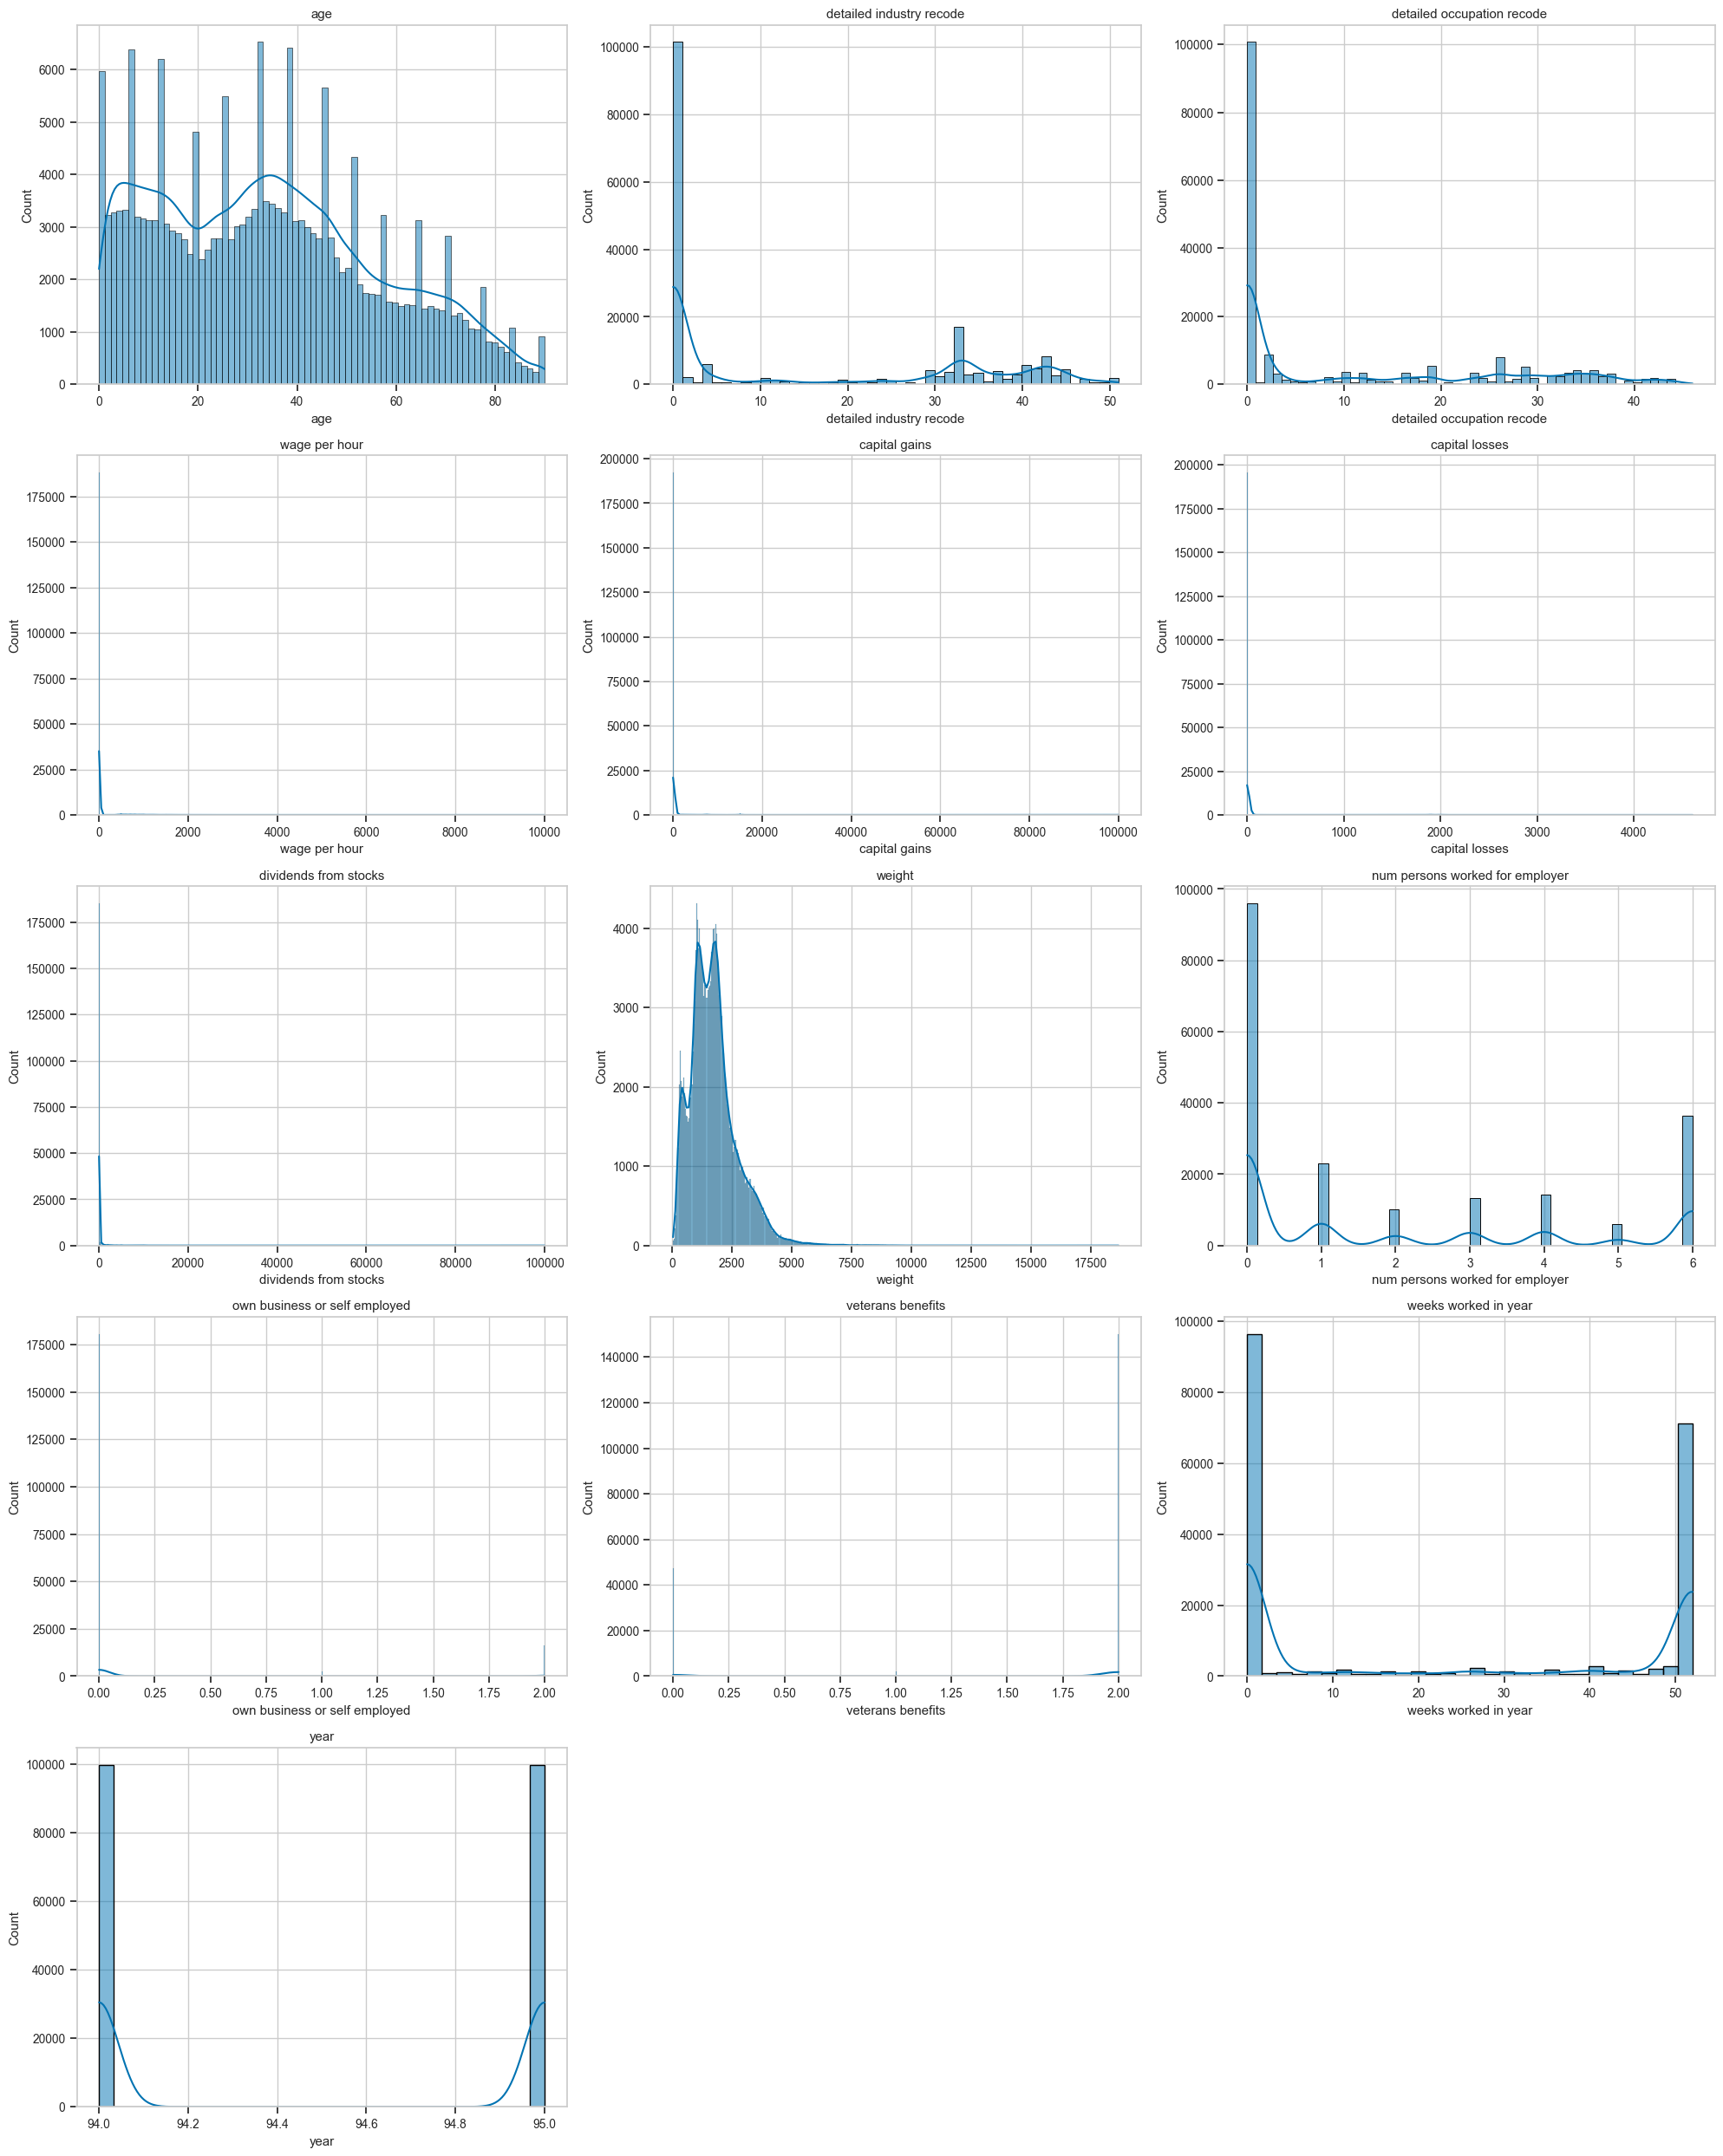


--------------------------------------------------------------------------------
                       Categorical Feature Distributions                        
--------------------------------------------------------------------------------


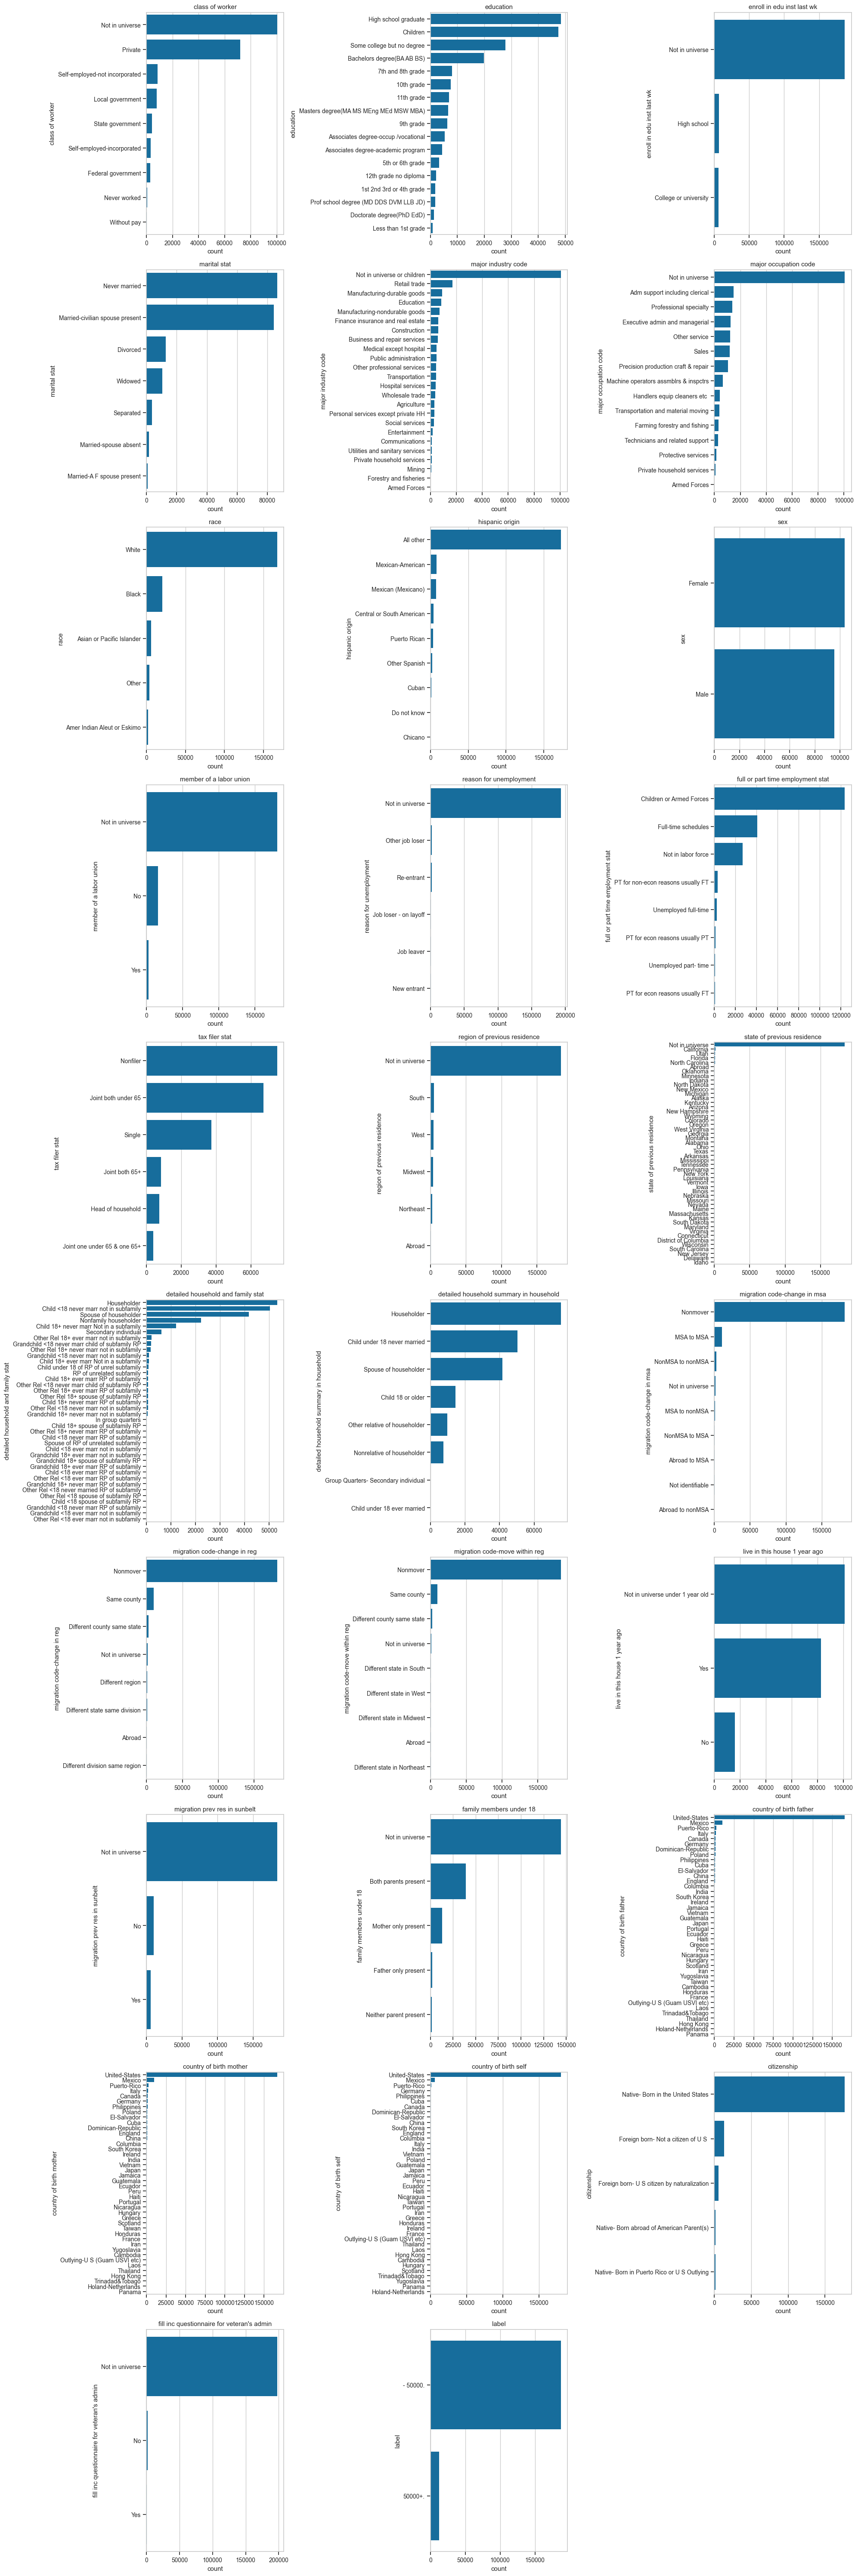


--------------------------------------------------------------------------------
                   Age Distribution by Income Group (Boxplot)                   
--------------------------------------------------------------------------------


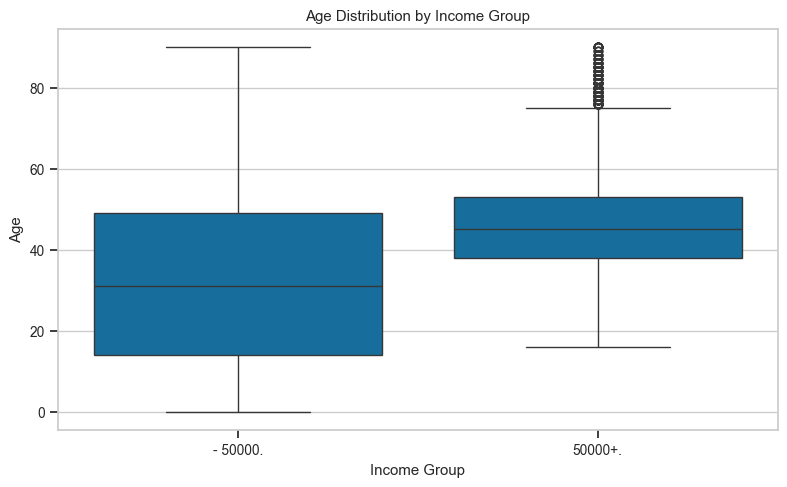


--------------------------------------------------------------------------------
                      Overall Sex Distribution (Pie Chart)                      
--------------------------------------------------------------------------------


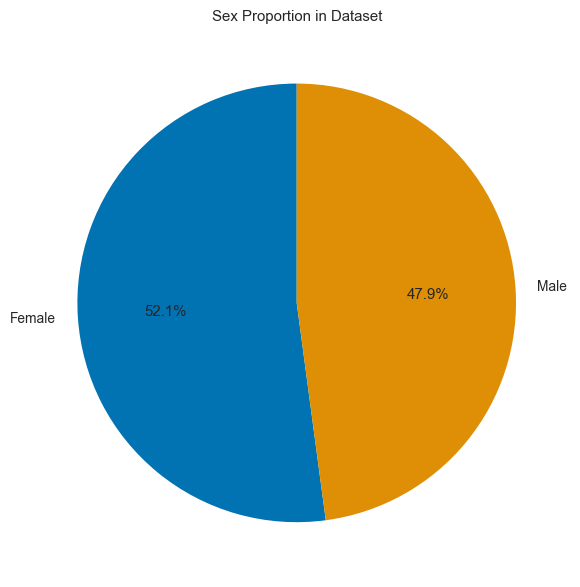


--------------------------------------------------------------------------------
                   Education vs Mean Wage per Hour (Bar Plot)                   
--------------------------------------------------------------------------------


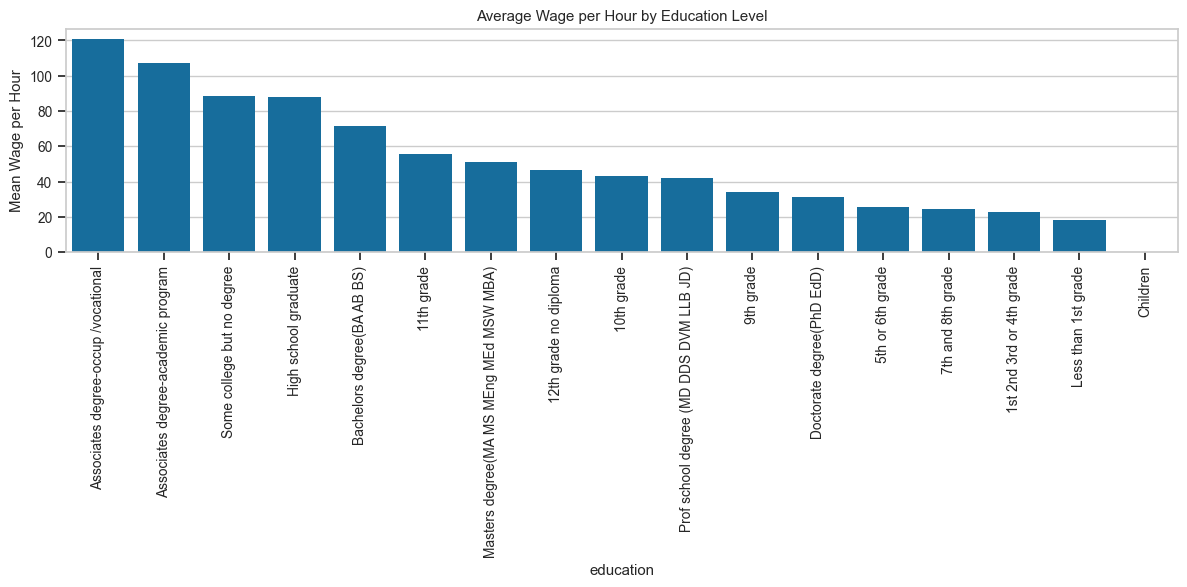


--------------------------------------------------------------------------------
                Sex Distribution by Income Group (<50K vs >50K)                 
--------------------------------------------------------------------------------


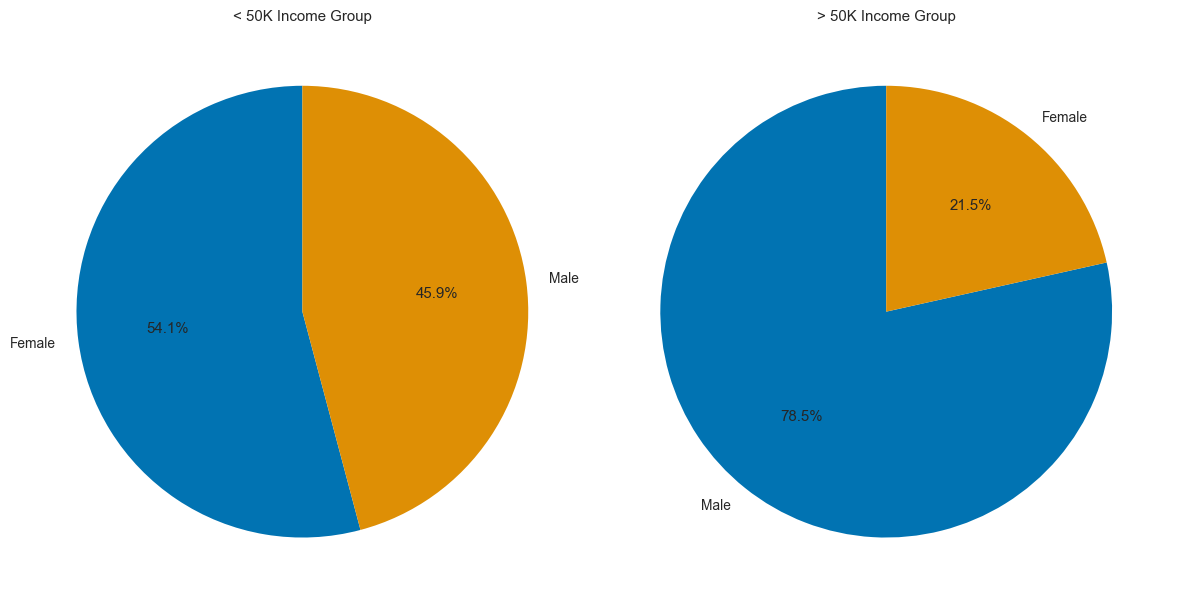


--------------------------------------------------------------------------------
             Top Categorical Features vs Income Label (Countplots)              
--------------------------------------------------------------------------------


/var/folders/0t/cwr8pwld733c67s6jbb8rcb80000gn/T/ipykernel_48851/3197005669.py:14: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include="object").columns.tolist()


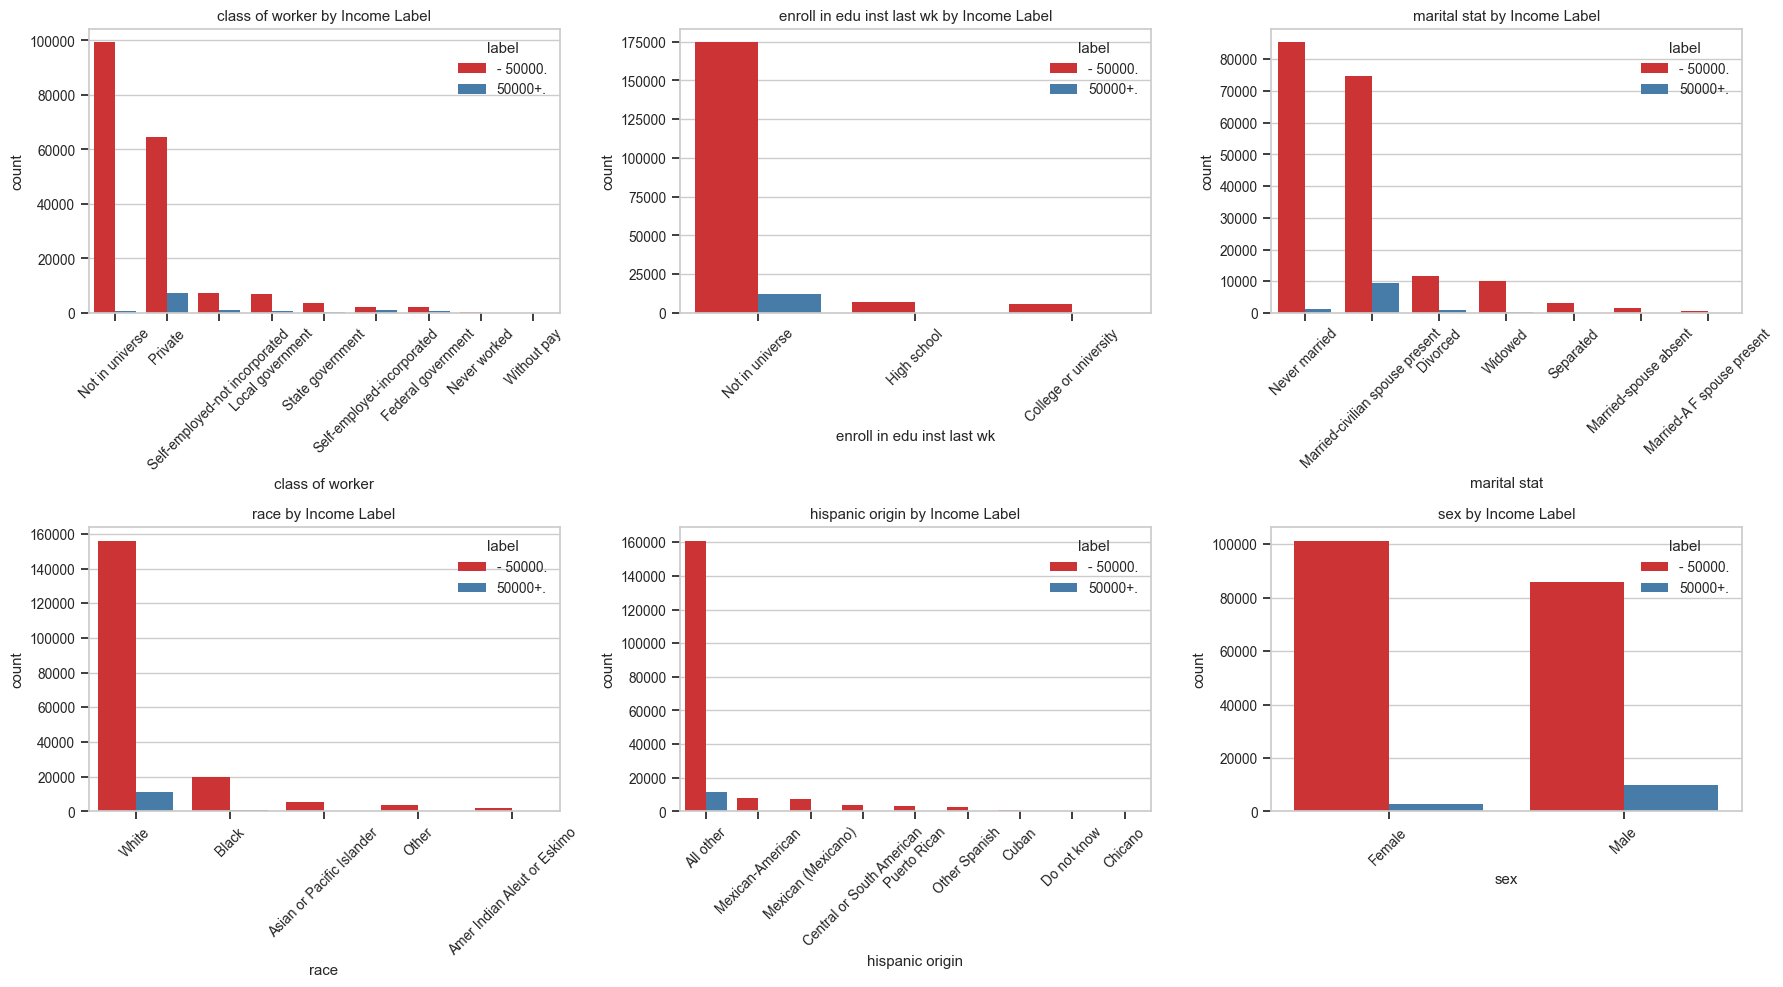


--------------------------------------------------------------------------------
                        Target Distribution - Pie chart                         
--------------------------------------------------------------------------------


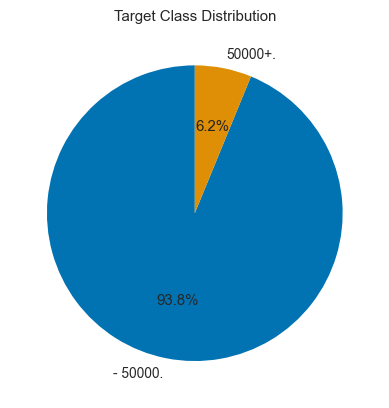


--------------------------------------------------------------------------------
                              Correlation Heatmap                               
--------------------------------------------------------------------------------


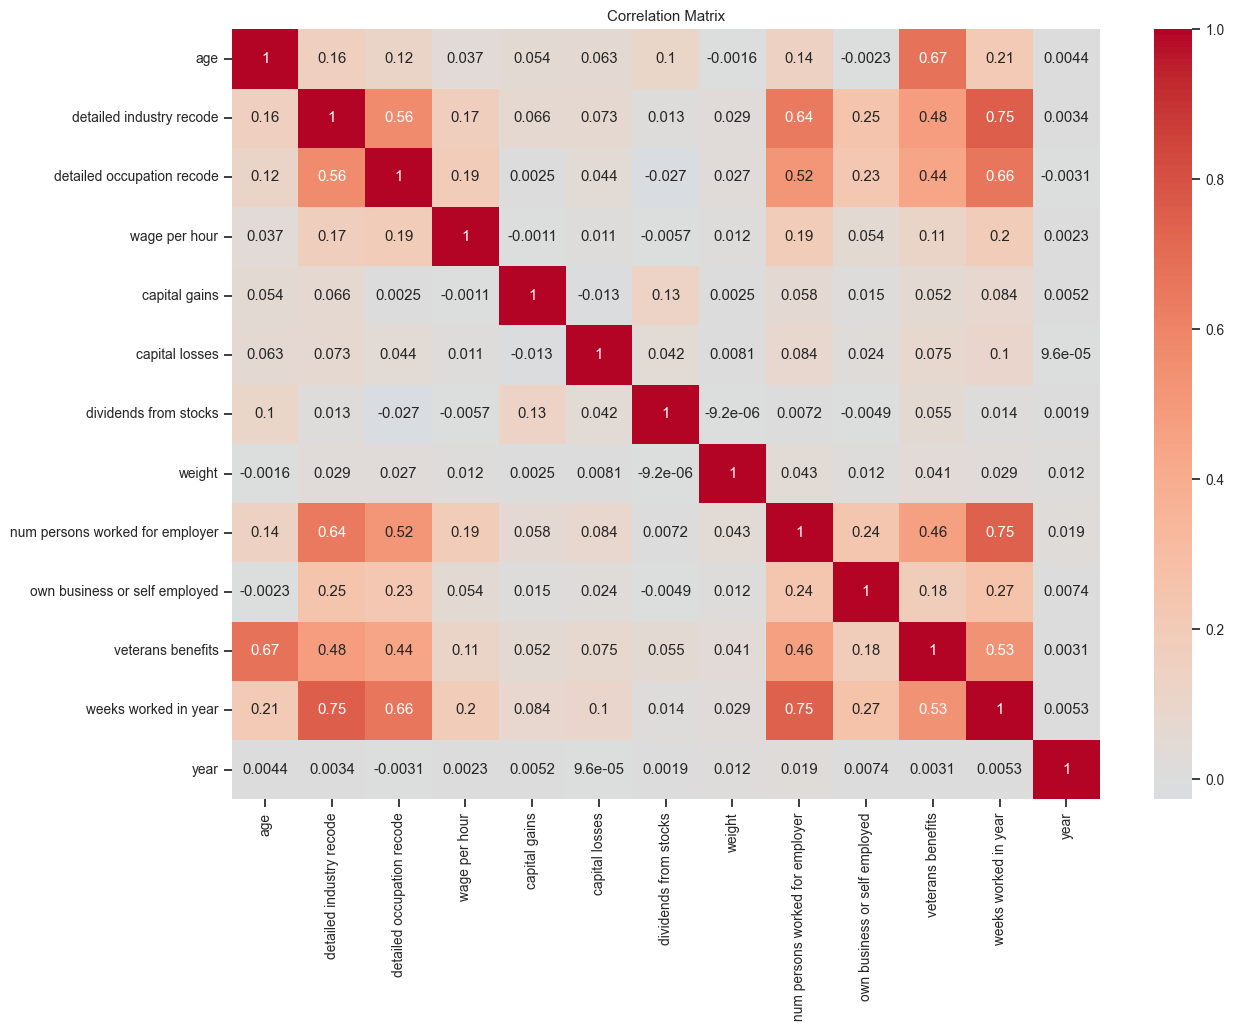

In [60]:
print_section("2.  EXPLORATORY DATA ANALYSIS (EDA)", level=1)
run_eda_pipeline(df_raw)

# Part 1 — Classification model

## 7.4 Supervised Modeling


                         3.  SUPERVISED CLASSIFICATION                          

--------------------------------------------------------------------------------
                          Training Logistic Regression                          
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
                         Evaluating Logistic Regression                         
--------------------------------------------------------------------------------

................................................................................
                             Classification Report                              
................................................................................
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     37429
           1       0.25      0.88      0.39      2476

    accuracy          

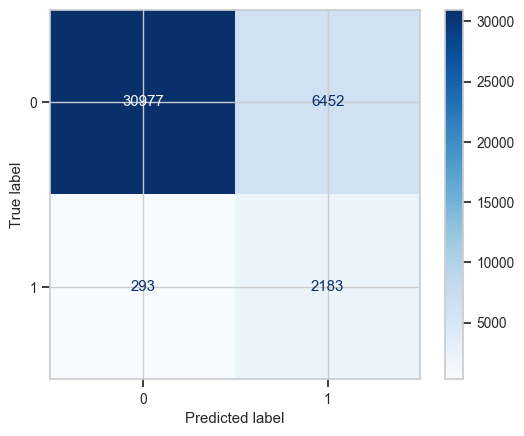


--------------------------------------------------------------------------------
                                  Training GBM                                  
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
                                 Evaluating GBM                                 
--------------------------------------------------------------------------------

................................................................................
                             Classification Report                              
................................................................................
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37429
           1       0.76      0.41      0.53      2476

    accuracy                           0.96     39905
   macro avg       0.86      0.70      0.75     39

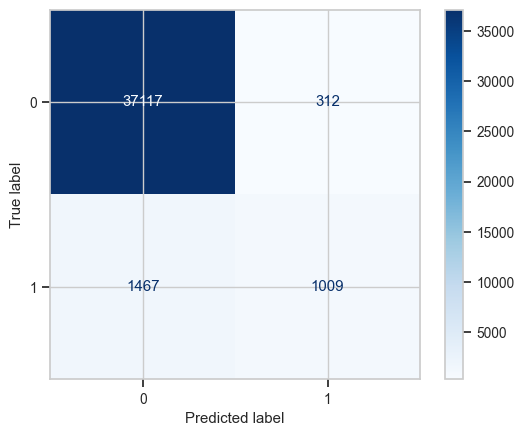


--------------------------------------------------------------------------------
                                Training XGBoost                                
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
                               Evaluating XGBoost                               
--------------------------------------------------------------------------------

................................................................................
                             Classification Report                              
................................................................................
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     37429
           1       0.37      0.85      0.52      2476

    accuracy                           0.90     39905
   macro avg       0.68      0.88      0.73     39

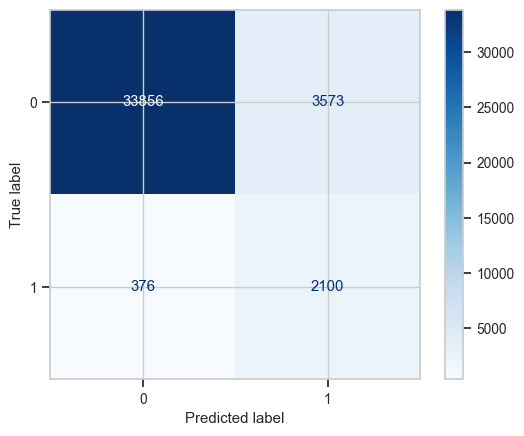


--------------------------------------------------------------------------------
                   Model Comparison – Metric-wise Evaluation                    
--------------------------------------------------------------------------------


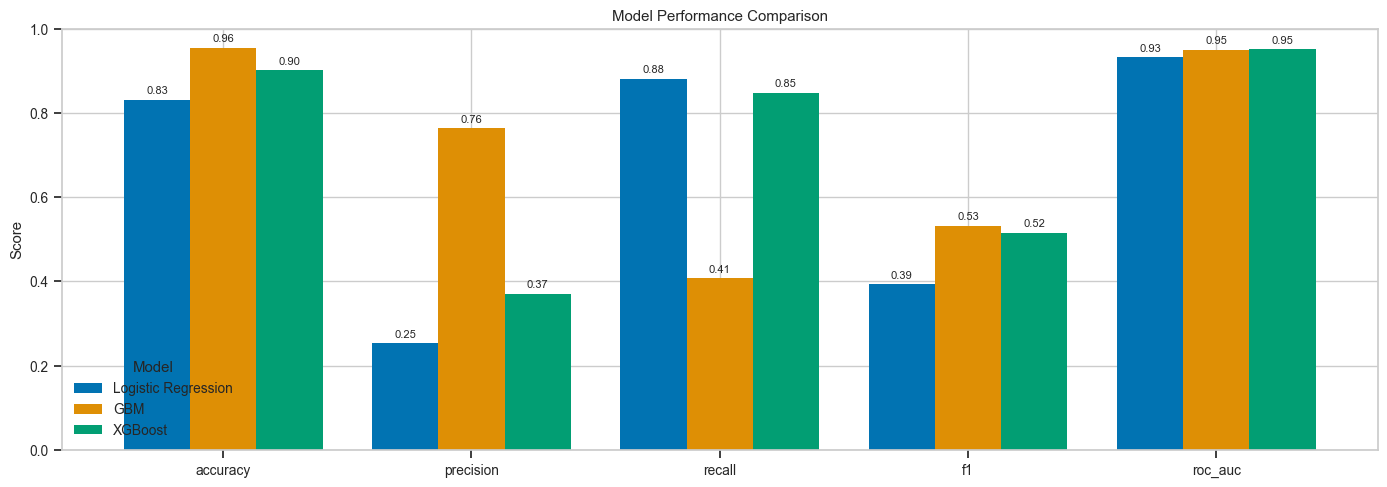


--------------------------------------------------------------------------------
                              ROC Curve Comparison                              
--------------------------------------------------------------------------------


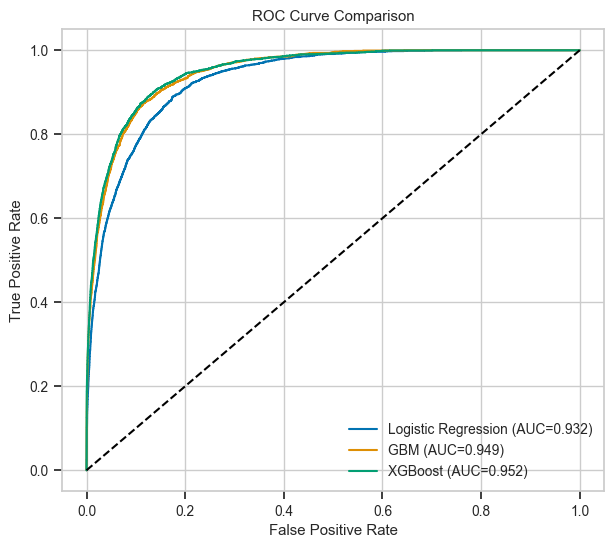


--------------------------------------------------------------------------------
                       Precision–Recall Curve Comparison                        
--------------------------------------------------------------------------------


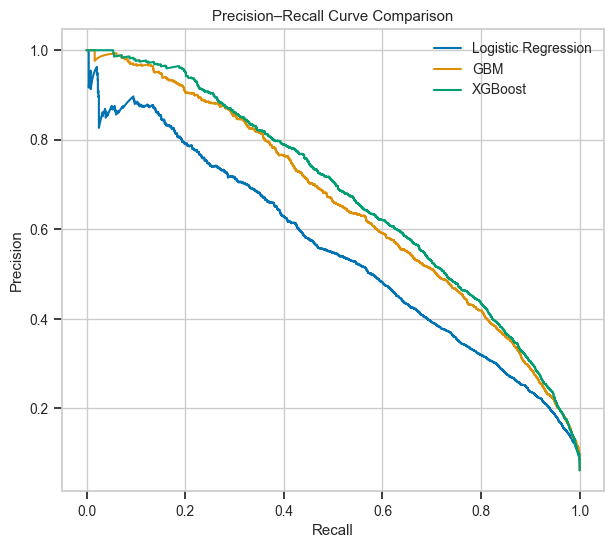

[I 2026-02-13 10:29:33,567] A new study created in memory with name: no-name-c055276d-84ed-4243-83d8-81b0f38c84de



--------------------------------------------------------------------------------
       Business Decision: Model Selection Based on Precision@Recall ≥ 0.4       
--------------------------------------------------------------------------------
Precision@Recall = {'Logistic Regression': np.float64(0.6292063492063492), 'GBM': np.float64(0.7656129529683886), 'XGBoost': np.float64(0.7896825396825397)}

                         Selected Winner Model: XGBoost                         

--------------------------------------------------------------------------------
                        Hyperparameter Tuning -> XGBoost                        
--------------------------------------------------------------------------------


[I 2026-02-13 10:29:36,056] Trial 0 finished with value: 0.9556824626192635 and parameters: {'n_estimators': 694, 'learning_rate': 0.01943741348194232, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8872955494045403, 'colsample_bytree': 0.7422849620112013, 'gamma': 1.5654990469176044}. Best is trial 0 with value: 0.9556824626192635.
[I 2026-02-13 10:29:37,763] Trial 1 finished with value: 0.9532451392838508 and parameters: {'n_estimators': 456, 'learning_rate': 0.05392234786107094, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9660082636978504, 'colsample_bytree': 0.8750220546552105, 'gamma': 2.7022881978792697}. Best is trial 0 with value: 0.9556824626192635.
[I 2026-02-13 10:29:39,798] Trial 2 finished with value: 0.9549710888264009 and parameters: {'n_estimators': 793, 'learning_rate': 0.0479546023033551, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7800841603819569, 'colsample_bytree': 0.8852945822449821, 'gamma': 2.237364971686504}. Best is trial 0 with va


................................................................................
                             Classification Report                              
................................................................................
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     37429
           1       0.34      0.89      0.49      2476

    accuracy                           0.89     39905
   macro avg       0.67      0.89      0.72     39905
weighted avg       0.95      0.89      0.91     39905

ROC AUC: 0.9561392078425621

................................................................................
                                Confusion Matrix                                
................................................................................


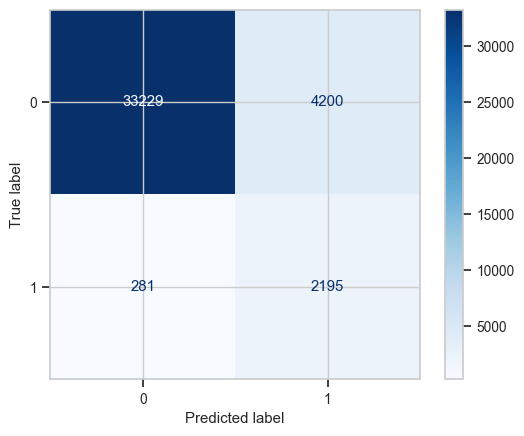

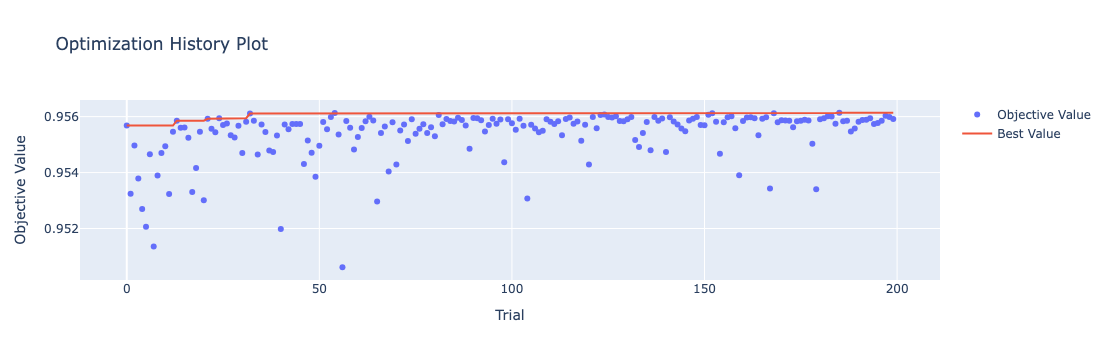

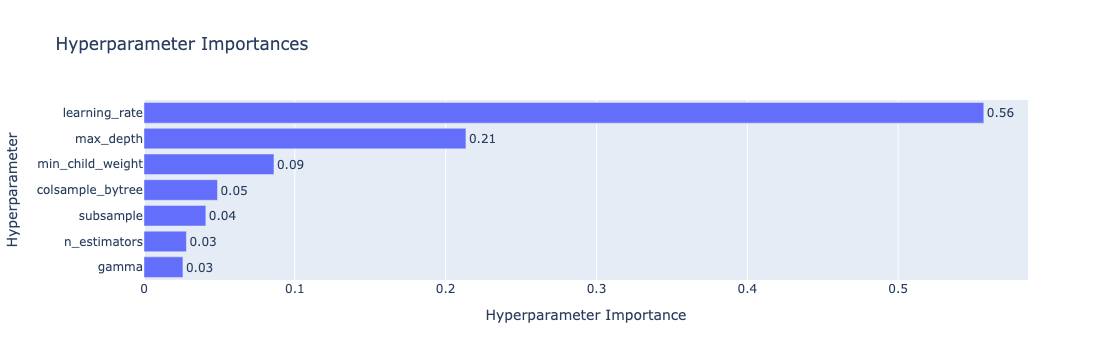

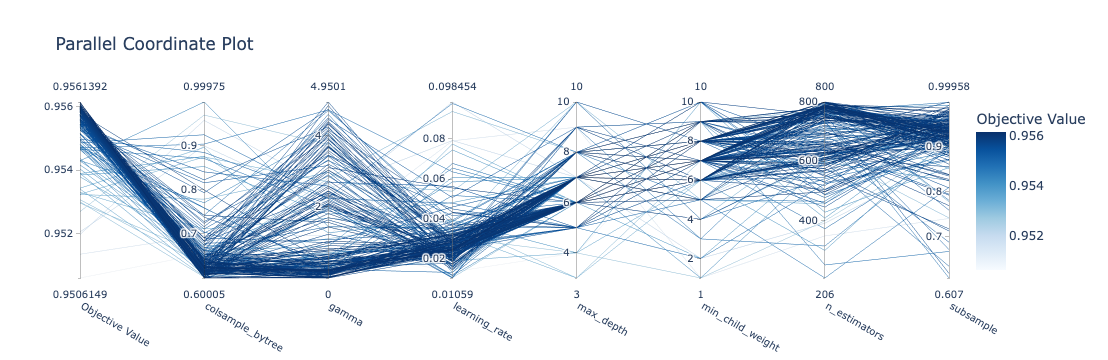

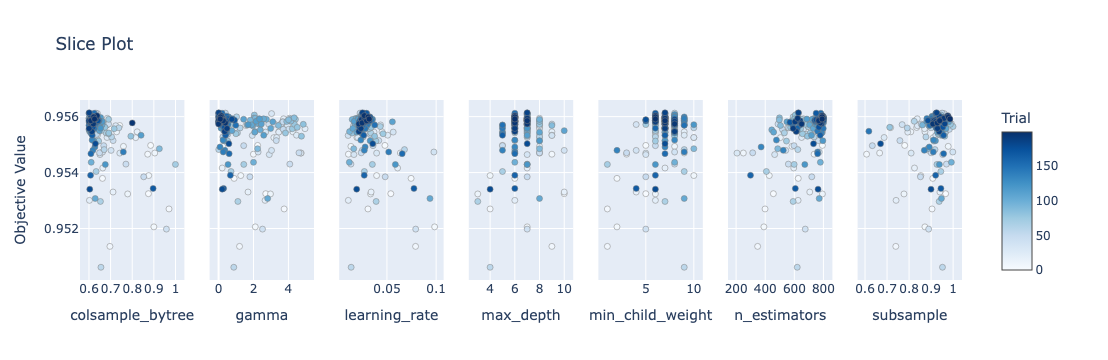

In [61]:
print_section("3.  SUPERVISED CLASSIFICATION", level=1)
run_modeling_pipeline(df_fe_v1, hp_tuning_trails= 2)

# Part 2 — Segmentation model

## 7.5 Customer Segmentation


                           4.  CUSTOMER SEGMENTATION                            


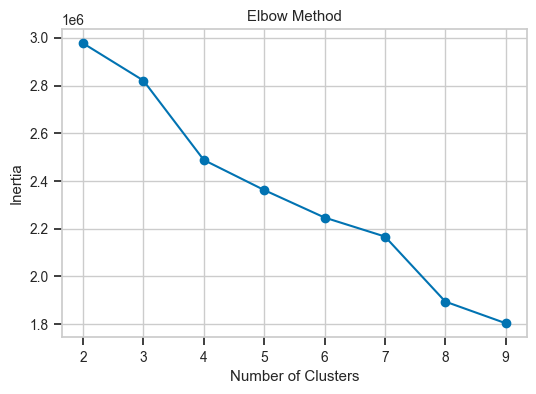

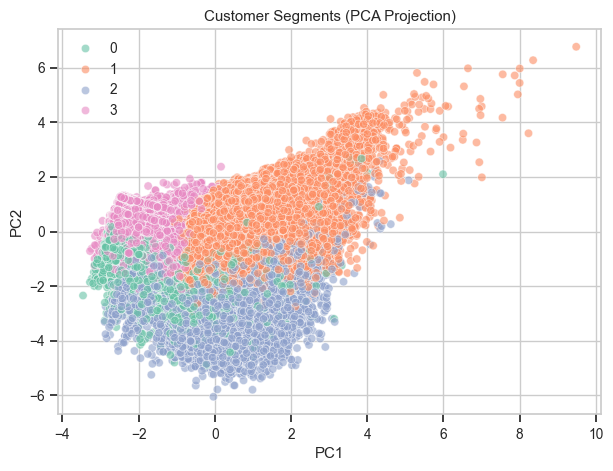


--------------------------------------------------------------------------------
                           Segment Size Distribution                            
--------------------------------------------------------------------------------


segment
0     15073
1    117512
2     19380
3     47558
Name: count, dtype: int64


--------------------------------------------------------------------------------
                 Segment-Level Numerical Profile (Mean Values)                  
--------------------------------------------------------------------------------


,age,weeks worked in year,wage per hour,capital gains,capital losses,dividends from stocks
segment,,,,,,
0,24.604392,16.255689,29.348305,169.160021,21.618125,28.336628
1,45.484470,32.434543,80.912732,648.912885,53.960064,314.540660
2,39.182353,26.368008,48.594840,402.202270,33.982198,98.757895
3,8.562156,1.186825,3.502902,2.879789,2.514382,2.277997



--------------------------------------------------------------------------------
                     Segment-Level Categorical Distribution                     
--------------------------------------------------------------------------------

................................................................................
                       education Distribution by Segment                        
................................................................................


segment,0,1,2,3
education,,,,
10th grade,731,3910,683,2233
11th grade,672,4116,656,1432
12th grade no diploma,231,1209,412,274
1st 2nd 3rd or 4th grade,276,548,970,5
5th or 6th grade,280,1043,1922,32
7th and 8th grade,655,4710,1267,1375
9th grade,647,2531,861,2191
Associates degree-academic program,208,3722,424,9
Associates degree-occup /vocational,220,4692,436,10



................................................................................
                    class of worker Distribution by Segment                     
................................................................................


segment,0,1,2,3
class of worker,,,,
Federal government,196,2482,204,43
Local government,560,6658,434,132
Never worked,64,89,76,210
Not in universe,9626,37394,8122,45103
Private,4056,57014,9081,1877
Self-employed-incorporated,68,2771,391,35
Self-employed-not incorporated,235,7325,760,125
State government,256,3660,296,15
Without pay,12,119,16,18



................................................................................
                          sex Distribution by Segment                           
................................................................................


segment,0,1,2,3
sex,,,,
Female,7993,62475,10205,23311
Male,7080,55037,9175,24247



................................................................................
                         label Distribution by Segment                          
................................................................................


segment,0,1,2,3
label,,,,
- 50000.,14762,106523,18300,47556
50000+.,311,10989,1080,2



--------------------------------------------------------------------------------
                           Segmentation Summary Table                           
--------------------------------------------------------------------------------


,Avg Age,Weeks Worked,Wage/hr,Capital Gains,Dividends,High-Income Rate (%),Share of High-Income Population (%),Segment Size
segment,,,,,,,,
0,24.6,16.3,29.3,169,28,2.06%,2.51%,"15,073"
1,45.5,32.4,80.9,649,315,9.35%,88.75%,"117,512"
2,39.2,26.4,48.6,402,99,5.57%,8.72%,"19,380"
3,8.6,1.2,3.5,3,2,0.00%,0.02%,"47,558"



                           Advanced Business Analysis                           

--------------------------------------------------------------------------------
                                 Lift Analysis                                  
--------------------------------------------------------------------------------


,High Income Rate,Lift vs Population
segment,,
0,0.021,0.33
1,0.094,1.51
2,0.056,0.90
3,0.000,0.00



--------------------------------------------------------------------------------
                        Income Concentration by Segment                         
--------------------------------------------------------------------------------


segment
0    0.036
1    0.875
2    0.082
3    0.007
Name: income_proxy, dtype: float64


--------------------------------------------------------------------------------
                               Revenue Simulation                               
--------------------------------------------------------------------------------


,Segment Size,High Income Rate,Expected Buyers,Expected Revenue ($)
segment,,,,
0,15073,0.021,16.0,7775.0
1,117512,0.094,549.0,274725.0
2,19380,0.056,54.0,27000.0
3,47558,0.000,0.0,50.0



--------------------------------------------------------------------------------
                  Economic Profile Comparison Across Segments                   
--------------------------------------------------------------------------------


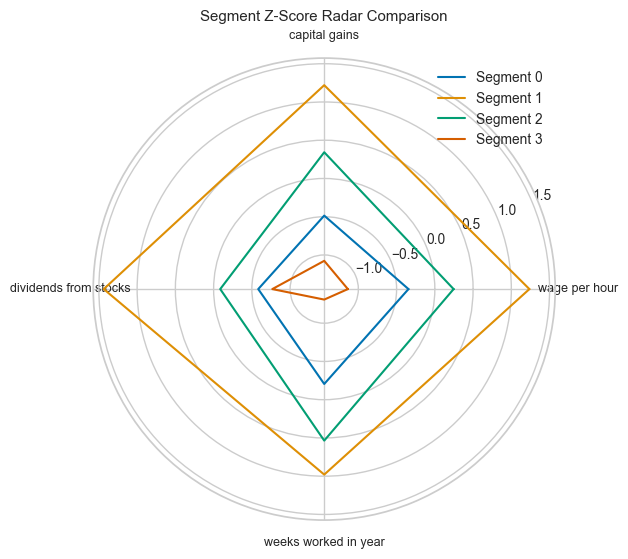


--------------------------------------------------------------------------------
                      Income Proxy Distribution by Segment                      
--------------------------------------------------------------------------------


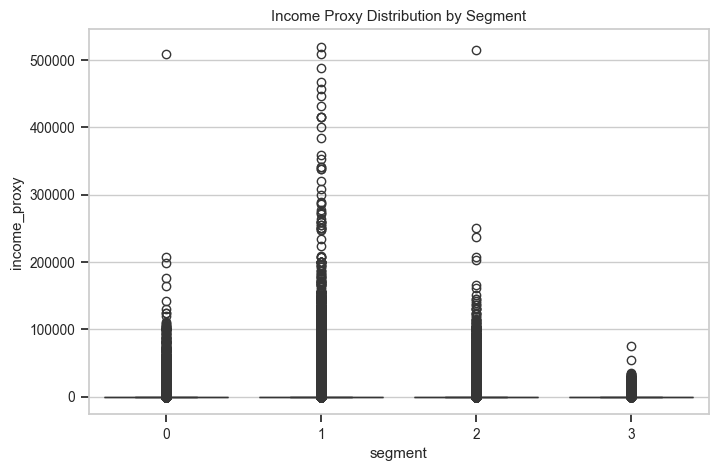

In [62]:
print_section("4.  CUSTOMER SEGMENTATION", level=1)
df_segmented, kmeans_model, seg_table = run_segmentation_pipeline(df_raw, n_clusters=4, evaluate_k=True)